# Base experiment notebook

This notebook is the template for all experiments.

It contains the basic code to run an experiment, and it is the starting point for all other notebooks in the folder `experiments`.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pickle
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import torch
import umap
from pytorch_lightning import callbacks, seed_everything
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorboard.backend.event_processing import event_accumulator
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    calculate_metrics_binary,
    plot_calibration_curve,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_precision_recall_curve_binary,
    plot_prediction_confidence,
    plot_roc_curve,
    plot_roc_curve_binary,
)

seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

## Definition of the notebook variables

In [3]:
# To change between experiments
BATCH_SIZE = 256
MAX_EPOCHS = 50


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False

# Language model
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
INPUT_DIM = 768

OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.9,
}

## More layers

### Definition of the net architecture

In [4]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self,
        root,
        embed_dim,
        inter_dim,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        num_layers=2,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.num_layers = num_layers

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.intervention_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        layers = [LinearUnit(inter_dim, inter_dim, dropout=dropout) for _ in range(num_layers - 1)]

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        var_repr = titre_repr + contexte_repr
        if self.noise > 0:
            var_repr = var_repr + torch.randn_like(var_repr) * self.noise

        pooled_repr = intervention_repr + var_repr

        logits = self.mlp(pooled_repr)

        return logits

### Experiment definition

In [5]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 768
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = True
NOISE = 0.05
NUM_LAYERS = 2

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}_{'F' if FEATURES else 'NF'}"
RESULTS_PATH = f"{BASE_ROOT}/{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}_{POSTFIX}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    MODEL_FOLDER,
    INPUT_DIM,
    HIDDEN_DIM,
    NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [6]:
trainer.fit(lit_model);

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                            | Type       | Params | In sizes  | Out sizes
----------------------------------------------------------------------------------------
0  | classifier                      | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings     | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc             | LinearUnit | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.fc          | Sequential | 590 K  | [32, 768] | [32, 768]
4  | classifier.titre_fc.fc.0        | Dropout    | 0      | [32, 768] | [32, 768]
5  | classi

Output()

Metric val_loss improved. New best score: 0.572
Epoch 0, global step 306: 'val_loss' reached 0.57239 (best 0.57239), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=0-step=306-v1.ckpt' as top 1


Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.552
Epoch 1, global step 612: 'val_loss' reached 0.55219 (best 0.55219), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.543
Epoch 2, global step 918: 'val_loss' reached 0.54279 (best 0.54279), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.534
Epoch 3, global step 1224: 'val_loss' reached 0.53441 (best 0.53441), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.525
Epoch 4, global step 1530: 'val_loss' reached 0.52532 (best 0.52532), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.522
Epoch 5, global step 1836: 'val_loss' reached 0.52244 (best 0.52244), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.517
Epoch 6, global step 2142: 'val_loss' reached 0.51678 (best 0.51678), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.514
Epoch 7, global step 2448: 'val_loss' reached 0.51383 (best 0.51383), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.510
Epoch 8, global step 2754: 'val_loss' reached 0.51030 (best 0.51030), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.509
Epoch 9, global step 3060: 'val_loss' reached 0.50910 (best 0.50910), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.504
Epoch 10, global step 3366: 'val_loss' reached 0.50429 (best 0.50429), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Epoch 11, global step 3672: 'val_loss' reached 0.50375 (best 0.50375), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.503
Epoch 12, global step 3978: 'val_loss' reached 0.50271 (best 0.50271), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=12-step=3978.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.501
Epoch 13, global step 4284: 'val_loss' reached 0.50062 (best 0.50062), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.500
Epoch 14, global step 4590: 'val_loss' reached 0.49957 (best 0.49957), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.500. Signaling Trainer to stop.
Epoch 29, global step 9180: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=14-step=4590.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/2_768_0.2_0.05_itc_F/lightning_logs/epoch=14-step=4590.ckpt


Output()

Metrics:  {'log_loss': 0.49361449164662036, 'accuracy': 0.7487283933503236, 'balanced_accuracy': 0.738877889996588, 'recall': 0.6785441198960086, 'precision': 0.7085218502155746, 'f1_score': 0.6932090407249244, 'AUC': 0.8304770711494728, 'jaccard_weighted': 0.5304666640098832, 'matthews_weighted': 0.4809318343138298, 'hamming_loss': 0.25127160664967635, 'confusion_matrix': [[43593, 10952], [12612, 26622]], 'confusion_matrix_true_normed': [[0.7992116600971675, 0.2007883399028325], [0.32145588010399145, 0.6785441198960086]], 'confusion_matrix_pred_normed': [[0.7756071523885776, 0.2914781497844254], [0.22439284761142247, 0.7085218502155746]], 'confusion_matrix_all_normed': [[0.4648482069546487, 0.11678520777572804], [0.13448639887394834, 0.2838801863956749]]}


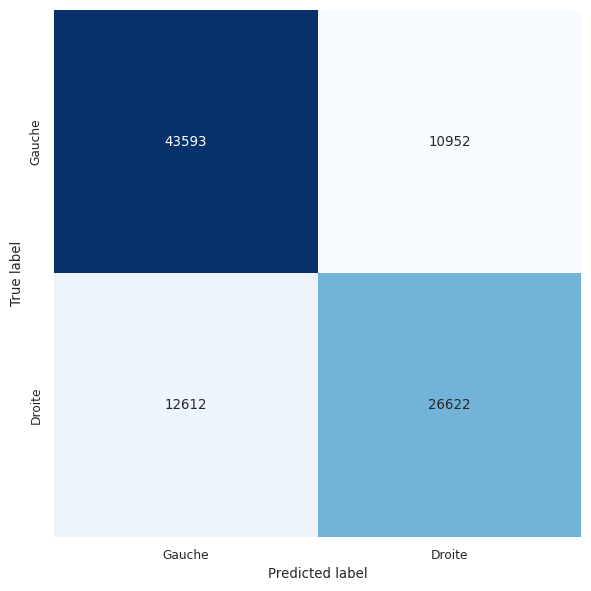

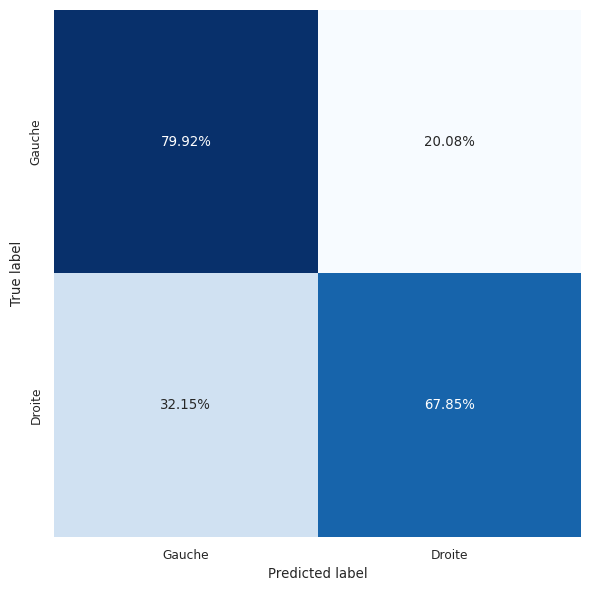

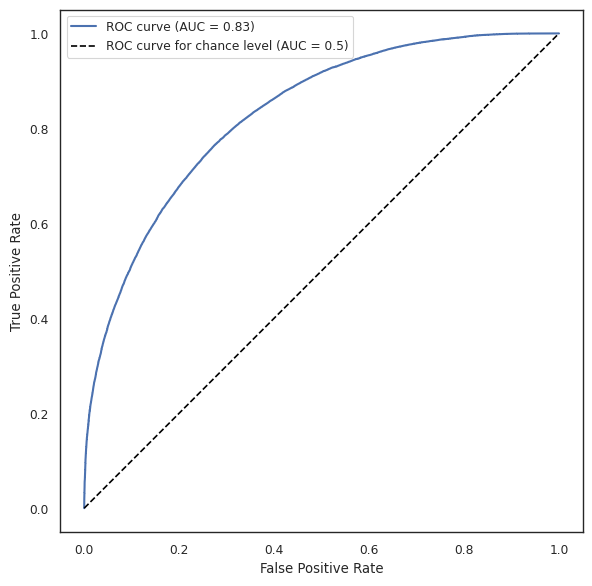

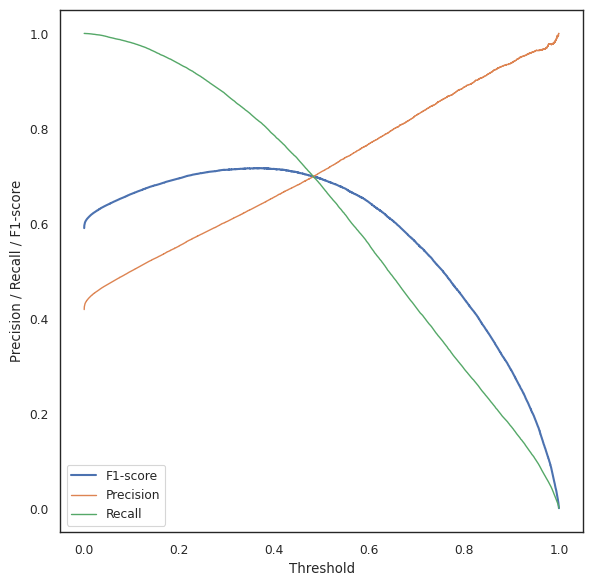

In [7]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## More layers and noise and bigger hidden size

### Definition of the net architecture

In [45]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self,
        root,
        embed_dim,
        inter_dim,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        num_layers=2,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.num_layers = num_layers

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.intervention_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        layers = [LinearUnit(inter_dim, inter_dim, dropout=dropout) for _ in range(num_layers - 1)]

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits

### Experiment definition

In [51]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 1024
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = False
NOISE = 0.02
NUM_LAYERS = 3

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}"
RESULTS_PATH = f"{BASE_ROOT}/{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}_{POSTFIX}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    MODEL_FOLDER,
    INPUT_DIM,
    HIDDEN_DIM,
    NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [52]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/3_1024_0.2_0.02_itc/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                            | Type       | Params | In sizes   | Out sizes 
------------------------------------------------------------------------------------------
0  | classifier                      | Net        | 8.7 M  | ?          | [32, 2]   
1  | classifier.titre_embeddings     | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc             | LinearUnit | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.fc          | Sequential | 787 K  | [32, 768]  | [32, 1024]
4  | classifier.titre_fc.fc.0        | Dropout    | 0      | [32, 768]  | [32, 768] 
5  | classifier.titre_fc.fc.1        | Linear     | 787 K  | [32, 768]  | [32, 1024]
6  | classifier.titre_fc.fc.2        | GELU       | 0      | [32, 1024] | [32, 1024]
7  | classifier.contexte_embeddings  | Embedding  | 363 K  | [32]       | [32, 768] 
8  | classifier.

Output()

Metric val_loss improved. New best score: 0.565
Epoch 0, global step 306: 'val_loss' reached 0.56497 (best 0.56497), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.541
Epoch 1, global step 612: 'val_loss' reached 0.54132 (best 0.54132), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.535
Epoch 2, global step 918: 'val_loss' reached 0.53491 (best 0.53491), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.521
Epoch 3, global step 1224: 'val_loss' reached 0.52109 (best 0.52109), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Epoch 4, global step 1530: 'val_loss' reached 0.52080 (best 0.52080), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.515
Epoch 5, global step 1836: 'val_loss' reached 0.51541 (best 0.51541), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.512
Epoch 6, global step 2142: 'val_loss' reached 0.51205 (best 0.51205), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' reached 0.51196 (best 0.51196), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.510
Epoch 9, global step 3060: 'val_loss' reached 0.51014 (best 0.51014), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.508
Epoch 14, global step 4590: 'val_loss' reached 0.50788 (best 0.50788), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.508. Signaling Trainer to stop.
Epoch 29, global step 9180: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=14-step=4590.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.2_0.02_itc/lightning_logs/epoch=14-step=4590.ckpt


Output()

Metrics:  {'log_loss': 0.5021675769521544, 'accuracy': 0.7483445120975911, 'balanced_accuracy': 0.7414311954579197, 'recall': 0.6990875261252995, 'precision': 0.6993014124725919, 'f1_score': 0.6991944529417763, 'AUC': 0.8312399425812449, 'jaccard_weighted': 0.5375088186877792, 'matthews_weighted': 0.48288313665372745, 'hamming_loss': 0.2516554879024089, 'confusion_matrix': [[42751, 11794], [11806, 27428]], 'confusion_matrix_true_normed': [[0.7837748647905399, 0.21622513520946007], [0.3009124738747005, 0.6990875261252995]], 'confusion_matrix_pred_normed': [[0.7836024708103452, 0.3006985875274081], [0.21639752918965485, 0.6993014124725919]], 'confusion_matrix_all_normed': [[0.45586965098796106, 0.12576376374241569], [0.12589172415999317, 0.2924748611096301]]}


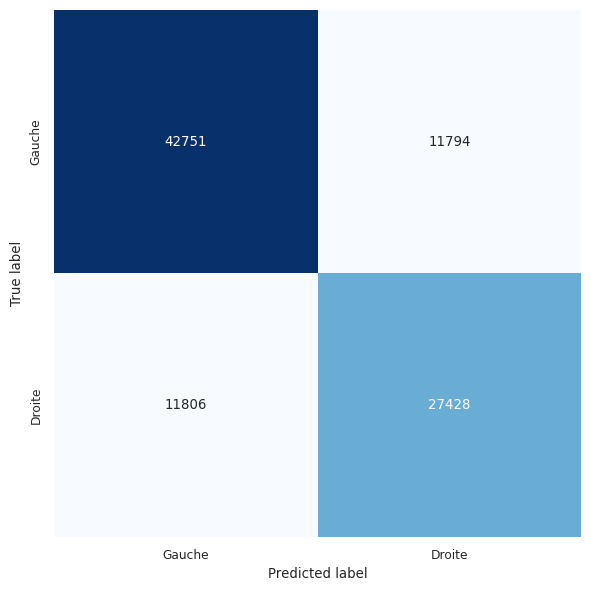

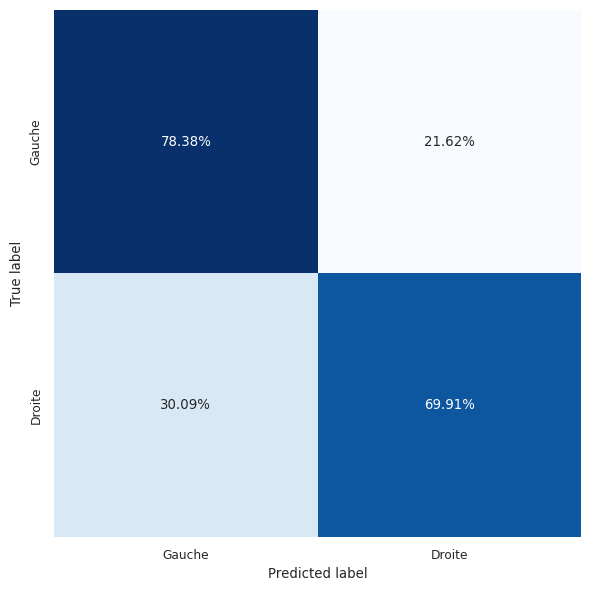

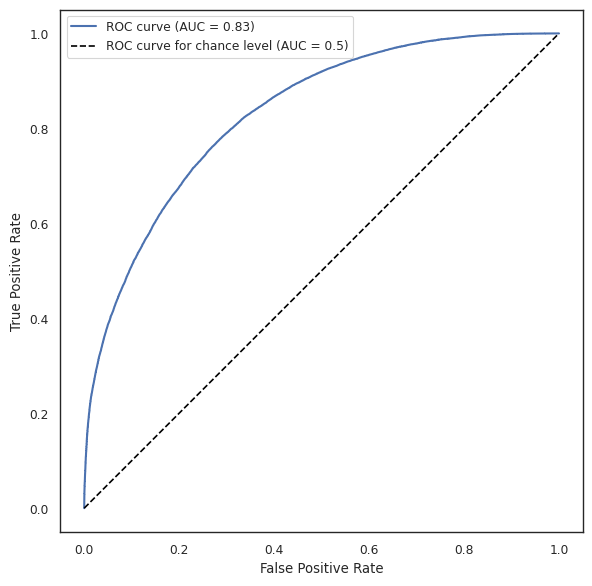

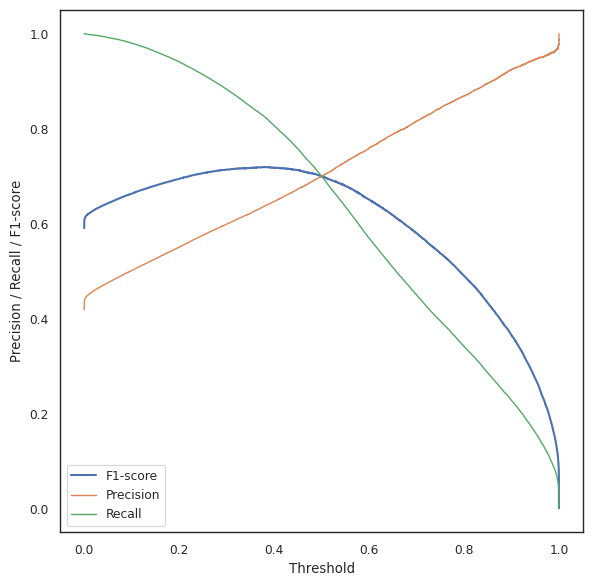

In [53]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Concatenation instead of addition

### Definition of the net architecture

In [4]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self,
        root,
        embed_dim,
        inter_dim,
        inter_dim2,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        num_layers=2,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.inter_dim2 = inter_dim2
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.num_layers = num_layers

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.intervention_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        layers = [LinearUnit(3 * inter_dim, inter_dim2, dropout=dropout)]
        layers.extend(
            [LinearUnit(inter_dim2, inter_dim2, dropout=dropout) for _ in range(num_layers - 2)]
        )

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim2, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        if self.noise > 0:
            titre_repr = titre_repr + torch.randn_like(titre_repr) * self.noise / 2
            contexte_repr = contexte_repr + torch.randn_like(contexte_repr) * self.noise / 2

        pooled_repr = torch.cat([intervention_repr, titre_repr, contexte_repr], dim=1)

        logits = self.mlp(pooled_repr)

        return logits

### Experiment definition

In [5]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 768
HIDDEN_DIM2 = 768
DROPOUT = 0.5
NUM_CLASSES = 2
FREEZE = False
NOISE = 0.1
NUM_LAYERS = 3

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}_{'F' if FEATURES else 'NF'}_CONT"
RESULTS_PATH = f"{BASE_ROOT}/{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}_{POSTFIX}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    inter_dim2=HIDDEN_DIM2,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
    freeze=FREEZE,
).to(device)


DROP_CENTER = NUM_CLASSES == 2
### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [6]:
trainer.fit(lit_model);

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                            | Type       | Params | In sizes   | Out sizes 
------------------------------------------------------------------------------------------
0  | classifier                      | Net        | 8.4 M  | ?          | [32, 2]   
1  | classifier.titre_embeddings     | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc             | LinearUnit | 590 K  | [32, 768]  | [32, 768] 
3  | classifier.titre_fc.fc          | Sequential | 590 K  | [32, 768]  | [32, 768] 
4  | classifier.titre_fc.fc.0        | Dropout    | 0      | [32, 768]  | [32,

Output()

Metric val_loss improved. New best score: 0.560
Epoch 0, global step 306: 'val_loss' reached 0.56003 (best 0.56003), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.535
Epoch 1, global step 612: 'val_loss' reached 0.53525 (best 0.53525), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.526
Epoch 2, global step 918: 'val_loss' reached 0.52602 (best 0.52602), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.522
Epoch 3, global step 1224: 'val_loss' reached 0.52210 (best 0.52210), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.517
Epoch 4, global step 1530: 'val_loss' reached 0.51657 (best 0.51657), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.514
Epoch 5, global step 1836: 'val_loss' reached 0.51357 (best 0.51357), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.511
Epoch 6, global step 2142: 'val_loss' reached 0.51069 (best 0.51069), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.509
Epoch 7, global step 2448: 'val_loss' reached 0.50942 (best 0.50942), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


Epoch 9, global step 3060: 'val_loss' reached 0.50878 (best 0.50878), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.506
Epoch 10, global step 3366: 'val_loss' reached 0.50584 (best 0.50584), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.505
Epoch 11, global step 3672: 'val_loss' reached 0.50484 (best 0.50484), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' reached 0.50480 (best 0.50480), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' reached 0.50403 (best 0.50403), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=16-step=5202.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.503
Epoch 17, global step 5508: 'val_loss' reached 0.50289 (best 0.50289), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Epoch 18, global step 5814: 'val_loss' reached 0.50225 (best 0.50225), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Epoch 31, global step 9792: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.503. Signaling Trainer to stop.
Epoch 32, global step 10098: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at ../../results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=24-step=7650.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../results/new_features/3_768_0.5_0.1_itc_F_CONT/lightning_logs/epoch=24-step=7650.ckpt


Output()

Metrics:  {'log_loss': 0.49799113251072247, 'accuracy': 0.7490696211305303, 'balanced_accuracy': 0.7357978267132108, 'recall': 0.6545088443696794, 'precision': 0.7201873457482612, 'f1_score': 0.6857791427426893, 'AUC': 0.8306152984572521, 'jaccard_weighted': 0.5218142285261426, 'matthews_weighted': 0.47922364594837236, 'hamming_loss': 0.25093037886946973, 'confusion_matrix': [[44568, 9977], [13555, 25679]], 'confusion_matrix_true_normed': [[0.8170868090567421, 0.18291319094325786], [0.3454911556303206, 0.6545088443696794]], 'confusion_matrix_pred_normed': [[0.7667876744146035, 0.27981265425173885], [0.23321232558539648, 0.7201873457482612]], 'confusion_matrix_all_normed': [[0.47524499088282024, 0.1063884238475565], [0.14454195502191322, 0.27382463024771003]]}


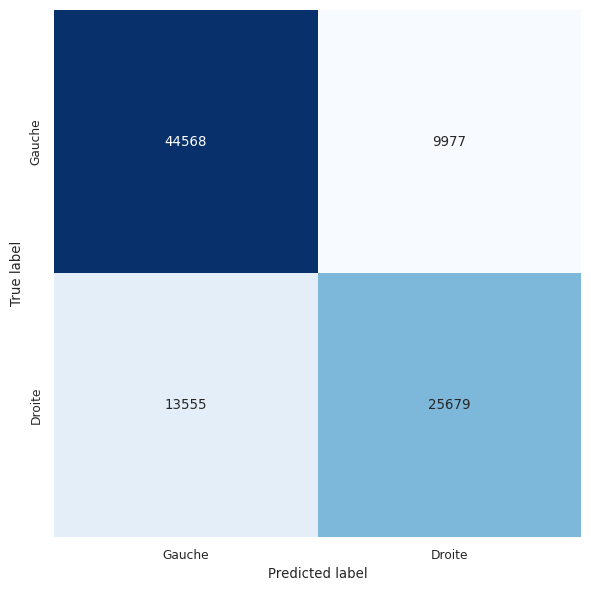

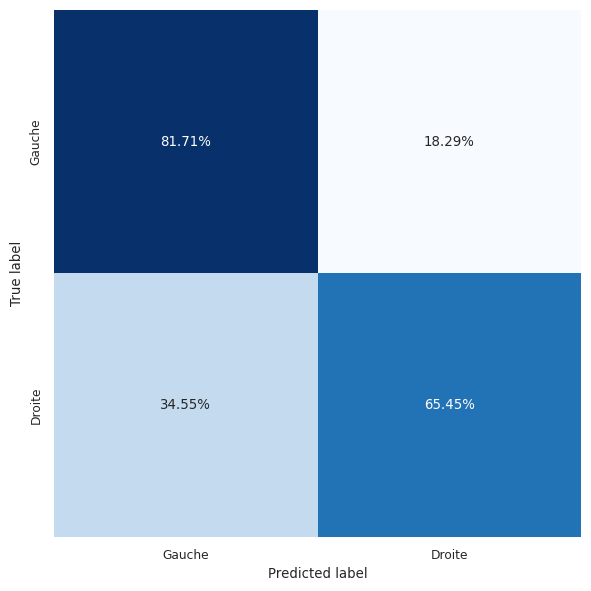

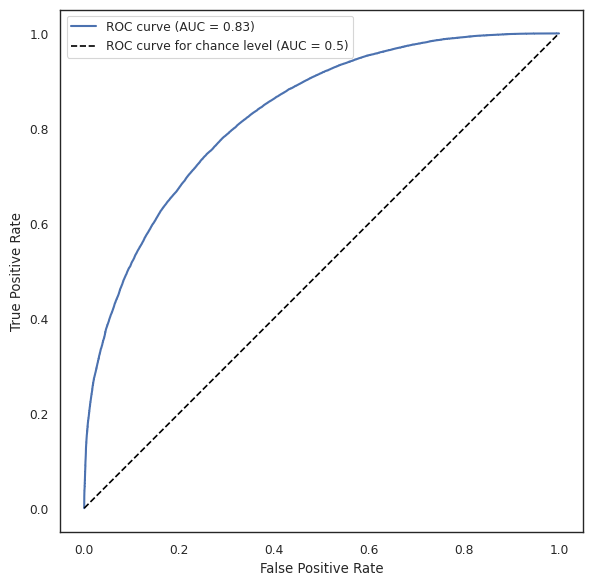

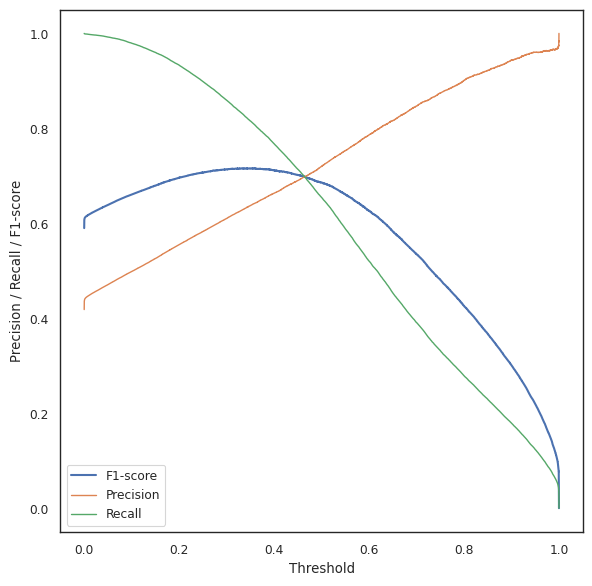

In [10]:
#### Prediction on test set
preds = trainer.predict(lit_model, ckpt_path=f"{CKPT_PATH}/epoch=24-step=7650.ckpt")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

### Embeddings visualization

#### Titre

In [26]:
folder_path = Path(MODEL_FOLDER)
f = folder_path / "titre_regexed/embeddings.pkl"

with open(f, "rb") as f:
    embs = pickle.load(f)

titre_emb = NET.titre_embeddings.weight.detach().cpu().numpy()
titre_to_int = embs["label_to_int"]

data = lit_model.test_dataloader().dataset

titre = data.text["titre_regexed"]
labels = data.labels

tmp_df = pd.DataFrame({"titre": titre, "label": labels})
color = tmp_df.sort_values("titre").groupby("titre")["label"].mean().to_dict()
size = tmp_df.sort_values("titre").groupby("titre")["label"].count().to_dict()
color_2 = {k: v for k, v in color.items() if (v != 0) and (v != 1)}


def plot_emb_proj(
    projection, embedding_dict, label_to_int, color, size, var, width=1200, height=1200
):
    idx = list(color.keys())
    embedding_df = pd.DataFrame(embedding_dict.T[idx], index=idx)
    int_to_label = {v: k for k, v in label_to_int.items()}

    if projection == "umap":
        fit = umap.UMAP()
    elif projection == "tsne":
        fit = TSNE(n_components=2, random_state=0)
    elif projection == "pca":
        fit = PCA(n_components=2)

    proj = fit.fit_transform(embedding_df)
    proj_df = pd.DataFrame(proj, columns=[f"{projection}-x", f"{projection}-y"])
    proj_df[var] = embedding_df.index
    proj_df[var] = proj_df[var].map(int_to_label)
    proj_df["Orientation"] = embedding_df.index.map(color)
    proj_df["Size"] = embedding_df.index.map(size)
    proj_df["Size"] = np.log(proj_df["Size"] + 1)

    fig = px.scatter(
        proj_df,
        x=f"{projection}-x",
        y=f"{projection}-y",
        size="Size",
        color="Orientation",
        hover_name=var,
        width=width,
        height=height,
        color_continuous_scale=px.colors.diverging.Temps,
    )

    return fig

In [27]:
pca_fig = plot_emb_proj("pca", titre_emb.T, titre_to_int, color, size, "Titre")
pca_fig.write_html(Path(RESULTS_PATH) / "titre_pca.html")
pca_fig.write_image(Path(RESULTS_PATH) / "titre_pca.png")

umap_fig = plot_emb_proj("umap", titre_emb.T, titre_to_int, color, size, "Titre")
umap_fig.write_html(Path(RESULTS_PATH) / "titre_umap.html")
umap_fig.write_image(Path(RESULTS_PATH) / "titre_umap.png")

tsne_fig = plot_emb_proj("tsne", titre_emb.T, titre_to_int, color, size, "Titre")
tsne_fig.write_html(Path(RESULTS_PATH) / "titre_tsne.html")
tsne_fig.write_image(Path(RESULTS_PATH) / "titre_tsne.png")

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



#### Contexte

In [34]:
folder_path = Path(MODEL_FOLDER)
f = folder_path / "contexte/embeddings.pkl"

with open(f, "rb") as f:
    embs = pickle.load(f)

contexte_emb = NET.contexte_embeddings.weight.detach().cpu().numpy()
contexte_to_int = embs["label_to_int"]

data = lit_model.test_dataloader().dataset

titre = data.text["contexte"]
labels = data.labels

tmp_df = pd.DataFrame({"contexte": titre, "label": labels})
color = tmp_df.sort_values("contexte").groupby("contexte")["label"].mean().to_dict()
size = tmp_df.sort_values("contexte").groupby("contexte")["label"].count().to_dict()
color_2 = {k: v for k, v in color.items() if (v != 0) and (v != 1)}


def plot_emb_proj(
    projection, embedding_dict, label_to_int, color, size, var, width=1200, height=1200
):
    idx = list(color.keys())
    embedding_df = pd.DataFrame(embedding_dict.T[idx], index=idx)
    int_to_label = {v: k for k, v in label_to_int.items()}

    if projection == "umap":
        fit = umap.UMAP()
    elif projection == "tsne":
        fit = TSNE(n_components=2, random_state=0)
    elif projection == "pca":
        fit = PCA(n_components=2)

    proj = fit.fit_transform(embedding_df)
    proj_df = pd.DataFrame(proj, columns=[f"{projection}-x", f"{projection}-y"])
    proj_df[var] = embedding_df.index
    proj_df[var] = proj_df[var].map(int_to_label)
    proj_df["Orientation"] = embedding_df.index.map(color)
    proj_df["Size"] = embedding_df.index.map(size)
    proj_df["Size"] = np.log(proj_df["Size"] + 1)

    fig = px.scatter(
        proj_df,
        x=f"{projection}-x",
        y=f"{projection}-y",
        size="Size",
        color="Orientation",
        hover_name=var,
        width=width,
        height=height,
        color_continuous_scale=px.colors.diverging.Temps,
    )

    return fig

In [35]:
pca_fig = plot_emb_proj("pca", contexte_emb.T, contexte_to_int, color, size, "Contexte")
pca_fig.write_html(Path(RESULTS_PATH) / "contexte_pca.html")
pca_fig.write_image(Path(RESULTS_PATH) / "contexte_pca.png")

umap_fig = plot_emb_proj("umap", contexte_emb.T, contexte_to_int, color, size, "Contexte")
umap_fig.write_html(Path(RESULTS_PATH) / "contexte_umap.html")
umap_fig.write_image(Path(RESULTS_PATH) / "contexte_umap.png")

tsne_fig = plot_emb_proj("tsne", contexte_emb.T, contexte_to_int, color, size, "Contexte")
tsne_fig.write_html(Path(RESULTS_PATH) / "contexte_tsne.html")
tsne_fig.write_image(Path(RESULTS_PATH) / "contexte_tsne.png")

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Adding the profession

### Definition of the net architecture

In [29]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self,
        root,
        embed_dim,
        inter_dim,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        num_layers=2,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
                "profession": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.num_layers = num_layers

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.profession_embeddings = load_embedding(root, "profession", freeze=freeze)
        self.profession_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        self.intervention_fc = LinearUnit(embed_dim, inter_dim, dropout=dropout)

        layers = [LinearUnit(inter_dim, inter_dim, dropout=dropout) for _ in range(num_layers - 1)]

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]
        profession = x["text"]["profession"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        profession_emb = self.profession_embeddings(profession)
        profession_repr = self.profession_fc(profession_emb)

        var_repr = titre_repr + contexte_repr + profession_repr
        if self.noise > 0:
            var_repr = var_repr + torch.randn_like(var_repr) * self.noise

        pooled_repr = intervention_repr + var_repr

        logits = self.mlp(pooled_repr)

        return logits

### Experiment definition

In [30]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte", "profession"]

HIDDEN_DIM = 1024
DROPOUT = 0.3
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = True
NOISE = 0.1
NUM_LAYERS = 3

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}_{'F' if FEATURES else 'NF'}"
RESULTS_PATH = f"{BASE_ROOT}/{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}_{POSTFIX}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    MODEL_FOLDER,
    INPUT_DIM,
    HIDDEN_DIM,
    NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [31]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                             | Type       | Params | In sizes   | Out sizes 
-------------------------------------------------------------------------------------------
0  | classifier                       | Net        | 9.8 M  | ?          | [32, 2]   
1  | classifier.titre_embeddings      | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc              | LinearUnit | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.fc           | Sequential | 787 K  | [32, 768]  | [32, 1024]
4  | classifier.titre_fc.fc.0         | Dropout    | 0      | [32, 768]  | [32, 768] 
5  | classifier.titre_fc.fc.1         | Linear     | 787 K  | [32, 768]  | [32, 1024]
6  | classifier.titre_fc.fc.2         | GELU       | 0      | [32, 1024] | [32, 1024]
7  | classifier.contexte_embeddings   | Embedding  | 363 K  | [32]       | [32, 768] 
8  |

Output()

Metric val_loss improved. New best score: 0.218
Epoch 0, global step 306: 'val_loss' reached 0.21786 (best 0.21786), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.176
Epoch 1, global step 612: 'val_loss' reached 0.17605 (best 0.17605), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.150
Epoch 2, global step 918: 'val_loss' reached 0.14985 (best 0.14985), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.135
Epoch 3, global step 1224: 'val_loss' reached 0.13539 (best 0.13539), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.126
Epoch 4, global step 1530: 'val_loss' reached 0.12585 (best 0.12585), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.119
Epoch 5, global step 1836: 'val_loss' reached 0.11910 (best 0.11910), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.111
Epoch 6, global step 2142: 'val_loss' reached 0.11102 (best 0.11102), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.110
Epoch 7, global step 2448: 'val_loss' reached 0.10977 (best 0.10977), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.105
Epoch 8, global step 2754: 'val_loss' reached 0.10521 (best 0.10521), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.103
Epoch 9, global step 3060: 'val_loss' reached 0.10337 (best 0.10337), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.102
Epoch 10, global step 3366: 'val_loss' reached 0.10233 (best 0.10233), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.099
Epoch 11, global step 3672: 'val_loss' reached 0.09856 (best 0.09856), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Epoch 13, global step 4284: 'val_loss' was not in top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.097
Epoch 15, global step 4896: 'val_loss' reached 0.09705 (best 0.09705), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' was not in top 1


Epoch 19, global step 6120: 'val_loss' reached 0.09681 (best 0.09681), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=19-step=6120.ckpt' as top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.097. Signaling Trainer to stop.
Epoch 30, global step 9486: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=19-step=6120.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_1024_0.3_0.1_itcp_F/lightning_logs/epoch=19-step=6120.ckpt


Output()

Metrics:  {'log_loss': 0.09648242709876081, 'accuracy': 0.9615798846223568, 'balanced_accuracy': 0.9603077046720712, 'recall': 0.952515675179691, 'precision': 0.955511237247833, 'f1_score': 0.9540111047290828, 'AUC': 0.9946928966544977, 'jaccard_weighted': 0.9120661883145409, 'matthews_weighted': 0.9210240140630553, 'hamming_loss': 0.038420115377643185, 'confusion_matrix': [[52805, 1740], [1863, 37371]], 'confusion_matrix_true_normed': [[0.9680997341644514, 0.03190026583554863], [0.04748432482030891, 0.952515675179691]], 'confusion_matrix_pred_normed': [[0.96592156288871, 0.044488762752166906], [0.034078437111289966, 0.955511237247833]], 'confusion_matrix_all_normed': [[0.5630791541816398, 0.018554260548736923], [0.01986585482890626, 0.398500730440717]]}


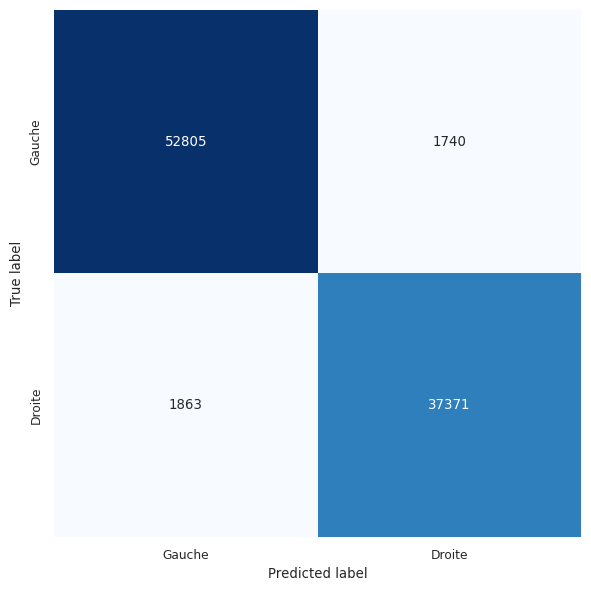

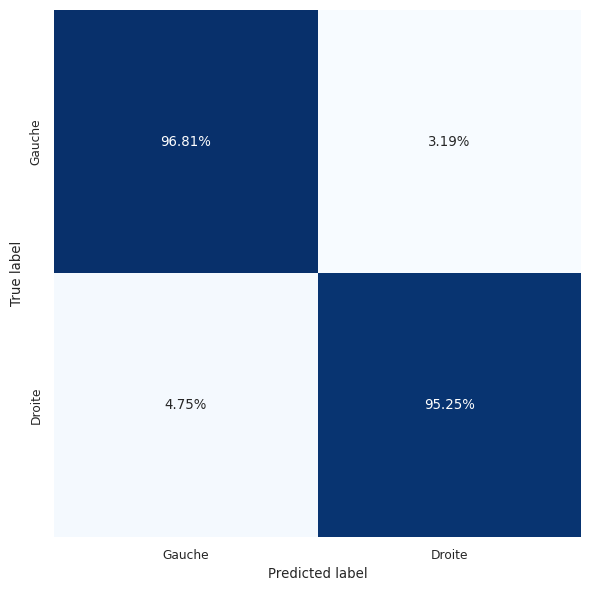

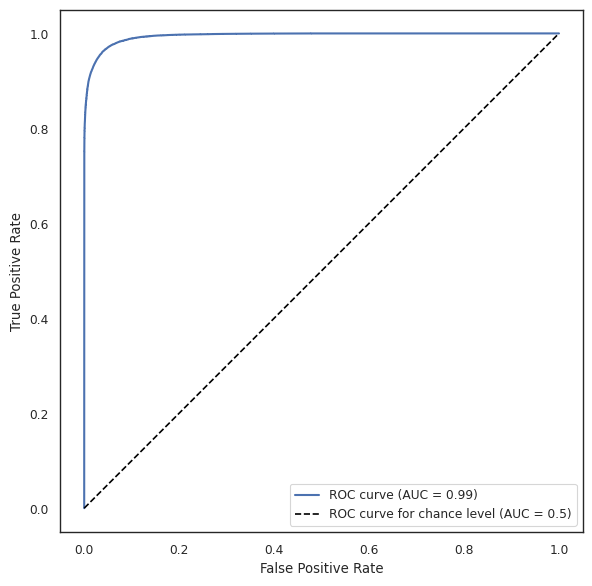

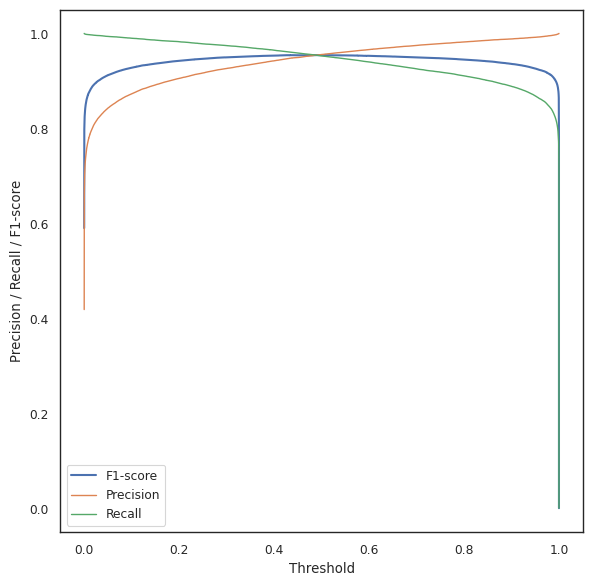

In [32]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

### Embeddings visualization

In [37]:
folder_path = Path(MODEL_FOLDER)
f = folder_path / "profession/embeddings.pkl"

with open(f, "rb") as f:
    embs = pickle.load(f)

profession_emb = NET.profession_embeddings.weight.detach().cpu().numpy()
profession_to_int = embs["label_to_int"]

data = lit_model.test_dataloader().dataset

profession = data.text["profession"]
labels = data.labels

tmp_df = pd.DataFrame({"profession": profession, "label": labels})
color = tmp_df.sort_values("profession").groupby("profession")["label"].mean().to_dict()
size = tmp_df.sort_values("profession").groupby("profession")["label"].count().to_dict()
color_2 = {k: v for k, v in color.items() if (v != 0) and (v != 1)}


def plot_emb_proj(
    projection, embedding_dict, label_to_int, color, size, var, width=1200, height=1200
):
    idx = list(color.keys())
    embedding_df = pd.DataFrame(embedding_dict.T[idx], index=idx)
    int_to_label = {v: k for k, v in label_to_int.items()}

    if projection == "umap":
        fit = umap.UMAP()
    elif projection == "tsne":
        fit = TSNE(n_components=2, random_state=0)
    elif projection == "pca":
        fit = PCA(n_components=2)

    proj = fit.fit_transform(embedding_df)
    proj_df = pd.DataFrame(proj, columns=[f"{projection}-x", f"{projection}-y"])
    proj_df[var] = embedding_df.index
    proj_df[var] = proj_df[var].map(int_to_label)
    proj_df["Orientation"] = embedding_df.index.map(color)
    proj_df["Size"] = embedding_df.index.map(size)
    proj_df["Size"] = np.log(proj_df["Size"] + 1)

    fig = px.scatter(
        proj_df,
        x=f"{projection}-x",
        y=f"{projection}-y",
        size="Size",
        color="Orientation",
        hover_name=var,
        width=width,
        height=height,
        color_continuous_scale=px.colors.diverging.Temps,
    )

    return fig

In [38]:
pca_fig = plot_emb_proj("pca", profession_emb.T, profession_to_int, color, size, "Profession")
pca_fig.write_html(Path(RESULTS_PATH) / "profession_pca.html")
pca_fig.write_image(Path(RESULTS_PATH) / "profession_pca.png")

umap_fig = plot_emb_proj("umap", profession_emb.T, profession_to_int, color, size, "Profession")
umap_fig.write_html(Path(RESULTS_PATH) / "profession_umap.html")
umap_fig.write_image(Path(RESULTS_PATH) / "profession_umap.png")

tsne_fig = plot_emb_proj("tsne", profession_emb.T, profession_to_int, color, size, "Profession")
tsne_fig.write_html(Path(RESULTS_PATH) / "profession_tsne.html")
tsne_fig.write_image(Path(RESULTS_PATH) / "profession_tsne.png")

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Adding the features

### Definition of the net architecture

In [5]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self,
        root,
        embed_dim,
        inter_dim,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        num_layers=2,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            },
            "features": torch.randn(32, 2),
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.num_layers = num_layers

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            LinearUnit(embed_dim, inter_dim // 2, dropout=dropout),
            LinearUnit(inter_dim // 2, inter_dim, dropout=dropout),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            LinearUnit(embed_dim, inter_dim // 2, dropout=dropout),
            LinearUnit(inter_dim // 2, inter_dim, dropout=dropout),
        )

        self.features_fc = nn.Sequential(
            LinearUnit(2, inter_dim // 2, dropout=dropout),
            LinearUnit(inter_dim // 2, inter_dim, dropout=dropout),
        )

        self.intervention_fc = nn.Sequential(
            LinearUnit(embed_dim, inter_dim // 2, dropout=dropout),
            LinearUnit(inter_dim // 2, inter_dim, dropout=dropout),
        )

        layers = [LinearUnit(inter_dim, inter_dim, dropout=dropout) for _ in range(num_layers - 2)]

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]
        features = x["features"].float()

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)

        var_repr = titre_repr + contexte_repr
        if self.noise > 0:
            var_repr = var_repr + torch.randn_like(var_repr) * self.noise

        pooled_repr = intervention + intervention_repr + var_repr + features_repr

        logits = self.mlp(pooled_repr)

        return logits

### Experiment definition

In [14]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 768
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = False
NOISE = 0.01
NUM_LAYERS = 4

OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "factor": 0.5,
    "monitor": "val_loss",
    "patience": 3,
}

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}_{'Features' if FEATURES else 'NF'}_{'Frozed' if FREEZE else 'Unfrozed'}_FF"
RESULTS_PATH = f"{BASE_ROOT}/{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}_{POSTFIX}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    MODEL_FOLDER,
    INPUT_DIM,
    HIDDEN_DIM,
    NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [15]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/4_768_0.2_0.01_itc_Features_Unfrozed_FF/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type       | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------------
0  | classifier                        | Net        | 7.5 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings       | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc               | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0             | LinearUnit | 295 K  | [32, 768] | [32, 384]
4  | classifier.titre_fc.0.fc          | Sequential | 295 K  | [32, 768] | [32, 384]
5  | classifier.titre_fc.0.fc.0        | Dropout    | 0      | [32, 768] | [32, 768]
6  | classifier.titre_fc.0.fc.1        | Linear     | 295 K  | [32, 768] | [32, 384]
7  | classifier.titre_fc.0.fc.2        | GELU       | 0      | [32, 384] | [32, 3

Output()

Metric val_loss improved. New best score: 0.543
Epoch 0, global step 306: 'val_loss' reached 0.54337 (best 0.54337), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/4_768_0.2_0.01_itc_Features_Unfrozed_FF/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.511
Epoch 1, global step 612: 'val_loss' reached 0.51100 (best 0.51100), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/4_768_0.2_0.01_itc_Features_Unfrozed_FF/lightning_logs/epoch=1-step=612.ckpt' as top 1


Epoch 2, global step 918: 'val_loss' was not in top 1


Epoch 3, global step 1224: 'val_loss' was not in top 1


Epoch 4, global step 1530: 'val_loss' was not in top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Epoch 6, global step 2142: 'val_loss' was not in top 1


Epoch 7, global step 2448: 'val_loss' was not in top 1


Epoch 8, global step 2754: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.2_0.0_itc_Features_Unfrozed_FF/lightning_logs/epoch=16-step=5202.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/3_768_0.2_0.0_itc_Features_Unfrozed_FF/lightning_logs/epoch=16-step=5202.ckpt


Output()

Metrics:  {'log_loss': 0.49198971429734845, 'accuracy': 0.748387165570117, 'balanced_accuracy': 0.7336049450001725, 'recall': 0.643064688790335, 'precision': 0.7245419562345644, 'f1_score': 0.6813762558064168, 'AUC': 0.8310843324800556, 'jaccard_weighted': 0.5167328882152952, 'matthews_weighted': 0.47700864556342426, 'hamming_loss': 0.251612834429883, 'confusion_matrix': [[44953, 9592], [14004, 25230]], 'confusion_matrix_true_normed': [[0.8241452012100101, 0.1758547987899899], [0.3569353112096651, 0.643064688790335]], 'confusion_matrix_pred_normed': [[0.7624709534067201, 0.27545804376543565], [0.23752904659327984, 0.7245419562345644]], 'confusion_matrix_all_normed': [[0.47935038761343157, 0.10228302711694516], [0.14932980731293785, 0.2690367779566854]]}


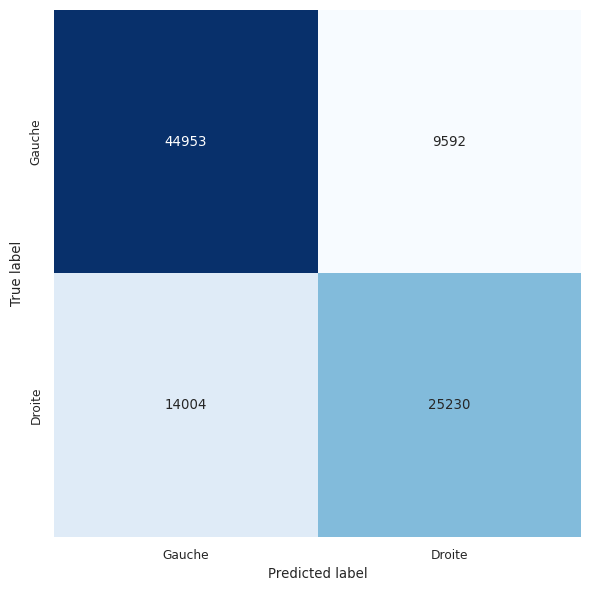

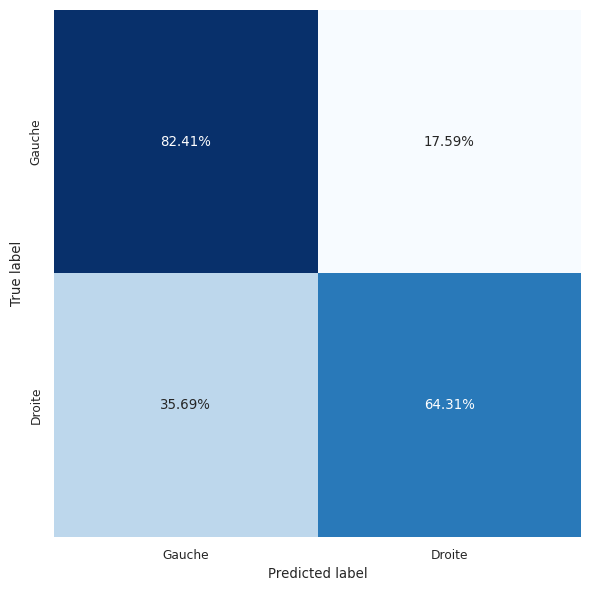

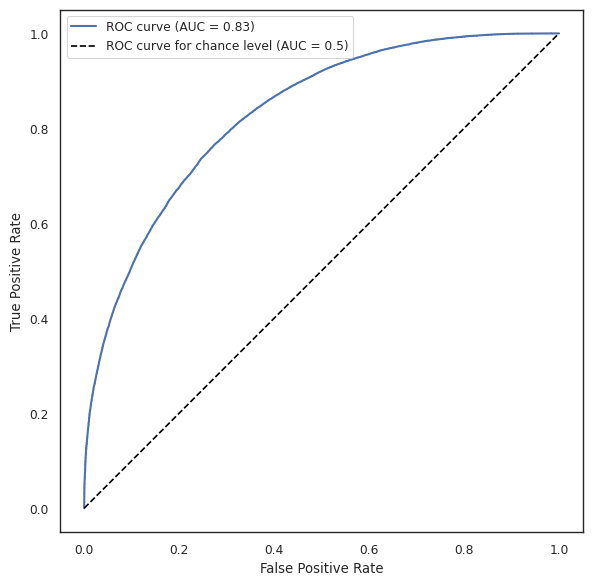

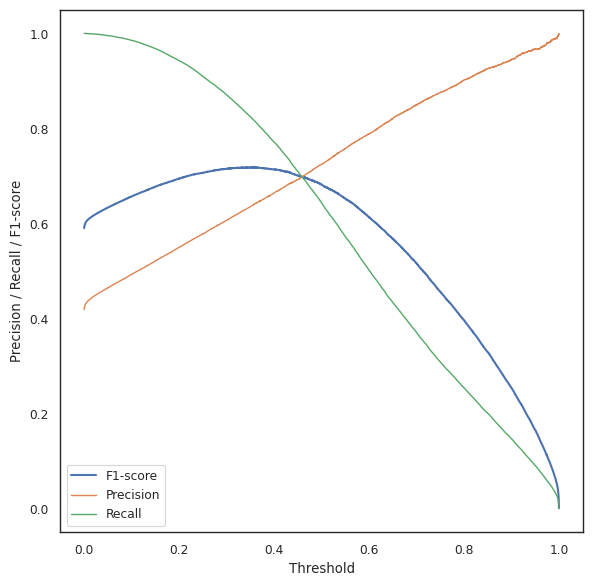

In [13]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Only interventions

### Definition of the net architecture

In [10]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class Net(nn.Module):
    def __init__(
        self, root, embed_dim, inter_dim, n_classes=2, dropout=0.2, noise=0.0, num_layers=2
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
            },
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.num_layers = num_layers
        self.noise = noise

        layers = [LinearUnit(embed_dim, inter_dim, dropout=dropout)]
        layers.extend(
            [LinearUnit(inter_dim, inter_dim, dropout=dropout) for _ in range(num_layers - 1)]
        )

        self.mlp = nn.Sequential(
            *layers,
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        if self.noise > 0:
            intervention = intervention + torch.randn_like(intervention) * self.noise

        logits = self.mlp(intervention)

        return logits

### Experiment definition

In [11]:
FEATURES = True
TEXT_VARS = ["intervention"]

HIDDEN_DIM = 1024
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = False
NOISE = 0.0
NUM_LAYERS = 4

OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {}
LR = 5e-4
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "factor": 0.5,
    "monitor": "val_loss",
    "patience": 3,
}

BASE_ROOT = "../../results/new_features"
POSTFIX = f"{''.join([f[0] for f in TEXT_VARS])}_{'Features' if FEATURES else 'NF'}"
RESULTS_PATH = f"{BASE_ROOT}/ONLY_I_{NUM_LAYERS}_{HIDDEN_DIM}_{DROPOUT}_{NOISE}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.001
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    embed_dim=INPUT_DIM,
    inter_dim=HIDDEN_DIM,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    num_layers=NUM_LAYERS,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [12]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                  | Type       | Params | In sizes   | Out sizes 
--------------------------------------------------------------------------------
0  | classifier            | Net        | 3.9 M  | ?          | [32, 2]   
1  | classifier.mlp        | Sequential | 3.9 M  | [32, 768]  | [32, 2]   
2  | classifier.mlp.0      | LinearUnit | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.mlp.0.fc   | Sequential | 787 K  | [32, 768]  | [32, 1024]
4  | classifier.mlp.0.fc.0 | Dropout    | 0      | [32, 768]  | [32, 768] 
5  | classifier.mlp.0.fc.1 | Linear     | 787 K  | [32, 768]  | [32, 1024]
6  | classifier.mlp.0.fc.2 | GELU       | 0      | [32, 1024] | [32, 1024]
7  | classifier.mlp.1      | LinearUnit | 1.0 M  | [32, 1024] | [32, 1024]
8  | classifier.mlp.1.fc   | Sequential | 1.0 M  | [32, 1024] | [32, 1024]
9  | classifier.mlp.1.fc.0 | Dropout   

Output()

Metric val_loss improved. New best score: 0.594
Epoch 0, global step 611: 'val_loss' reached 0.59359 (best 0.59359), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=0-step=611.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.592
Epoch 1, global step 1222: 'val_loss' reached 0.59239 (best 0.59239), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=1-step=1222.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.580
Epoch 2, global step 1833: 'val_loss' reached 0.58050 (best 0.58050), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=2-step=1833.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.577
Epoch 3, global step 2444: 'val_loss' reached 0.57717 (best 0.57717), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=3-step=2444.ckpt' as top 1


Epoch 4, global step 3055: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.576
Epoch 5, global step 3666: 'val_loss' reached 0.57607 (best 0.57607), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=5-step=3666.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.574
Epoch 6, global step 4277: 'val_loss' reached 0.57442 (best 0.57442), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=6-step=4277.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.566
Epoch 7, global step 4888: 'val_loss' reached 0.56626 (best 0.56626), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=7-step=4888.ckpt' as top 1


Epoch 8, global step 5499: 'val_loss' reached 0.56572 (best 0.56572), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=8-step=5499.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.564
Epoch 9, global step 6110: 'val_loss' reached 0.56390 (best 0.56390), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=9-step=6110.ckpt' as top 1


Epoch 10, global step 6721: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.562
Epoch 11, global step 7332: 'val_loss' reached 0.56159 (best 0.56159), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=11-step=7332.ckpt' as top 1


Epoch 12, global step 7943: 'val_loss' was not in top 1


Epoch 13, global step 8554: 'val_loss' was not in top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.560
Epoch 14, global step 9165: 'val_loss' reached 0.56002 (best 0.56002), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=14-step=9165.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.558
Epoch 15, global step 9776: 'val_loss' reached 0.55774 (best 0.55774), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=15-step=9776.ckpt' as top 1


Epoch 16, global step 10387: 'val_loss' was not in top 1


Epoch 17, global step 10998: 'val_loss' was not in top 1


Epoch 18, global step 11609: 'val_loss' was not in top 1


Epoch 19, global step 12220: 'val_loss' was not in top 1


Epoch 20, global step 12831: 'val_loss' was not in top 1


Epoch 21, global step 13442: 'val_loss' was not in top 1


Epoch 22, global step 14053: 'val_loss' was not in top 1


Epoch 23, global step 14664: 'val_loss' was not in top 1


Epoch 24, global step 15275: 'val_loss' was not in top 1


Epoch 25, global step 15886: 'val_loss' was not in top 1


Epoch 26, global step 16497: 'val_loss' was not in top 1


Epoch 27, global step 17108: 'val_loss' was not in top 1


Epoch 28, global step 17719: 'val_loss' was not in top 1


Epoch 29, global step 18330: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.558. Signaling Trainer to stop.
Epoch 30, global step 18941: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=15-step=9776.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ONLY_I_4_1024_0.2_0.0/lightning_logs/epoch=15-step=9776.ckpt


Output()

Metrics:  {'log_loss': 0.5557970264524295, 'accuracy': 0.70650145554975, 'balanced_accuracy': 0.684100804725275, 'recall': 0.5468980985879595, 'precision': 0.687636200487117, 'f1_score': 0.6092450097958488, 'AUC': 0.7750656754827259, 'jaccard_weighted': 0.4380678222167779, 'matthews_weighted': 0.3854684927627242, 'hamming_loss': 0.29349854445025003, 'confusion_matrix': [[44798, 9747], [17777, 21457]], 'confusion_matrix_true_normed': [[0.8213035108625906, 0.1786964891374095], [0.4531019014120406, 0.5468980985879595]], 'confusion_matrix_pred_normed': [[0.7159089093088294, 0.31236379951288296], [0.2840910906911706, 0.687636200487117]], 'confusion_matrix_all_normed': [[0.4776975655530556, 0.10393584917732115], [0.1895626952729289, 0.22880388999669435]]}


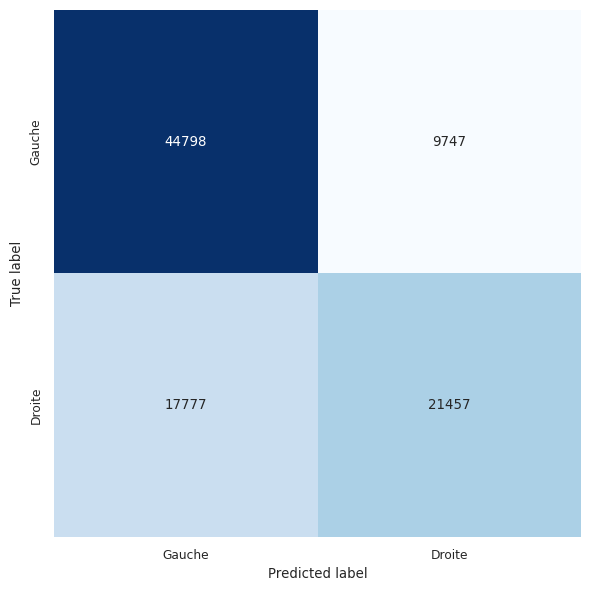

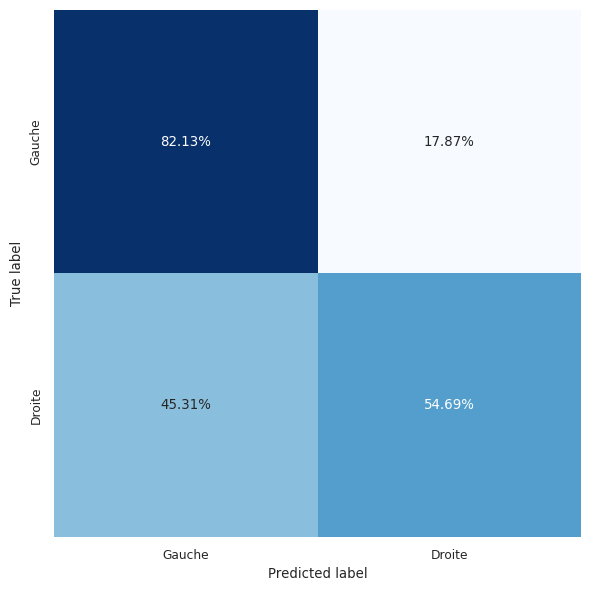

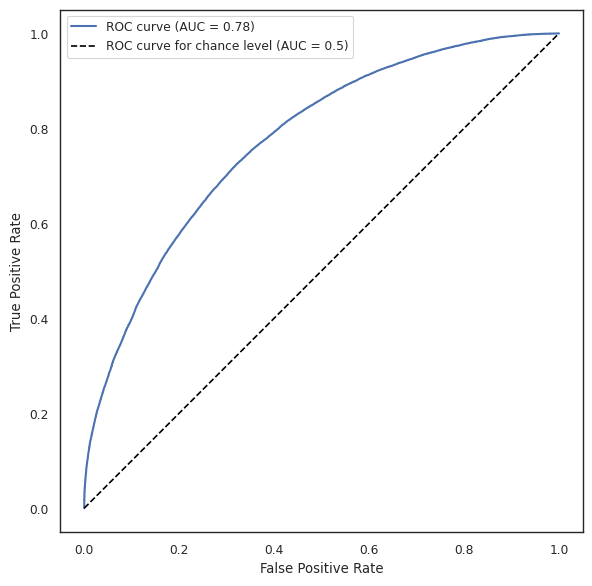

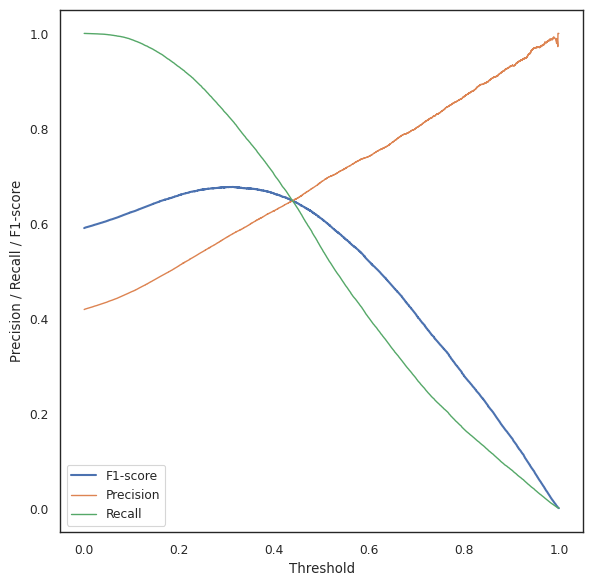

In [13]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Using an Attention Head

### Definition of the net architecture

In [140]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class AttentionUnit(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads=4, dropout=0.2):
        super().__init__()
        self.query_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.key_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.value_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.attn_head = nn.MultiheadAttention(out_dim, n_heads, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm((3, out_dim))

    def forward(self, x):
        query = self.query_linear(x)
        key = self.key_linear(x)
        value = self.value_linear(x)
        attn_repr, _ = self.attn_head(query, key, value, need_weights=False)
        normed_repr = self.layer_norm(attn_repr)
        return attn_repr


class Net(nn.Module):
    def __init__(
        self,
        root,
        input_dim,
        hidden_dim,
        feature_dim,
        n_heads=4,
        n_attn_layer=1,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, input_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            },
            "features": torch.randn(32, 2),
        }

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.n_attn_layer = n_attn_layer

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            LinearUnit(input_dim, hidden_dim, dropout=dropout),
            LinearUnit(hidden_dim, hidden_dim, dropout=dropout),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            LinearUnit(input_dim, hidden_dim, dropout=dropout),
            LinearUnit(hidden_dim, hidden_dim, dropout=dropout),
        )

        self.features_fc = nn.Sequential(
            LinearUnit(2, feature_dim // 2, dropout=dropout),
            LinearUnit(feature_dim // 2, feature_dim, dropout=dropout),
        )

        self.intervention_fc = nn.Sequential(
            LinearUnit(input_dim, hidden_dim, dropout=dropout),
            LinearUnit(hidden_dim, hidden_dim, dropout=dropout),
        )

        attn_layers = [
            AttentionUnit(hidden_dim, hidden_dim, n_heads, dropout=dropout)
            for i in range(n_attn_layer)
        ]

        self.attn_heads = nn.Sequential(*attn_layers)

        self.mlp = nn.Sequential(
            LinearUnit(hidden_dim + feature_dim, hidden_dim),
            nn.Linear(hidden_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]
        features = x["features"].float()

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)

        pooled_repr = torch.cat(
            [intervention_repr.unsqueeze(1), titre_repr.unsqueeze(1), contexte_repr.unsqueeze(1)],
            dim=1,
        )

        attn_repr = self.attn_heads(pooled_repr)

        final_repr = torch.cat([attn_repr[:, 0, :].squeeze(1), features_repr], dim=1)

        logits = self.mlp(final_repr)

        return logits

### Experiment definition

In [148]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 384
FEATURE_DIM = 32
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = False
N_HEADS = 8
N_ATTN_LAYERS = 3
NOISE = 0.01
MAX_EPOCHS = 200


OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {}
LR = 5e-4
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.85,
}

# SCHEDULER_KWARGS = {
#     "scheduler": "ReduceLROnPlateau",
#     "mode": "min",
#     "factor": 0.5,
#     "patience": 5,
#     "monitor": "val_loss"
# }

# SCHEDULER_KWARGS = {
#     "scheduler": "CosineAnnealingWarmRestarts",
#     "T_0": 3,
#     "T_mult": 2,
#     "eta_min": 0,
# }

BASE_ROOT = "../../results/new_features"
POSTFIX = f"ITC_Features_Attn_{N_HEADS}Hx{N_ATTN_LAYERS}@{HIDDEN_DIM}_LN_Unfrozen"
RESULTS_PATH = f"{BASE_ROOT}/{POSTFIX}_{DROPOUT}_{OPTIMIZER_TYPE}@{LR}_ExpLR@0.85"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.00
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=20,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=3),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    feature_dim=FEATURE_DIM,
    n_heads=N_HEADS,
    n_attn_layer=N_ATTN_LAYERS,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [149]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type          | Params | In sizes     | Out sizes   
------------------------------------------------------------------------------------------------
0  | classifier                     | Net           | 8.9 M  | ?            | [32, 2]     
1  | classifier.titre_embeddings    | Embedding     | 3.9 M  | [32]         | [32, 768]   
2  | classifier.titre_fc            | Sequential    | 443 K  | [32, 768]    | [32, 384]   
3  | classifier.titre_fc.0          | LinearUnit    | 295 K  | [32, 768]    | [32, 384]   
4  | classifier.titre_fc.1          | LinearUnit    | 147 K  | [32, 384]    | [32, 384]   
5  | classifier.contexte_embeddings | Embedding     | 363 K  | [32]         | [32, 768]   
6  | classifier.contexte_fc         | Sequential    | 443 K  | [32, 768]    | [32, 384]   


Output()

Metric val_loss improved. New best score: 0.564
Epoch 0, global step 306: 'val_loss' reached 0.56408 (best 0.56408), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.535
Epoch 1, global step 612: 'val_loss' reached 0.53463 (best 0.53463), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.530
Epoch 2, global step 918: 'val_loss' reached 0.53006 (best 0.53006), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.523
Epoch 3, global step 1224: 'val_loss' reached 0.52317 (best 0.52317), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.518
Epoch 4, global step 1530: 'val_loss' reached 0.51803 (best 0.51803), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Epoch 5, global step 1836: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.515
Epoch 6, global step 2142: 'val_loss' reached 0.51547 (best 0.51547), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.512
Epoch 7, global step 2448: 'val_loss' reached 0.51243 (best 0.51243), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.510
Epoch 8, global step 2754: 'val_loss' reached 0.51002 (best 0.51002), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Epoch 9, global step 3060: 'val_loss' was not in top 1


Epoch 10, global step 3366: 'val_loss' was not in top 1


Epoch 11, global step 3672: 'val_loss' was not in top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510
Epoch 13, global step 4284: 'val_loss' reached 0.50987 (best 0.50987), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Epoch 14, global step 4590: 'val_loss' was not in top 1


Epoch 15, global step 4896: 'val_loss' was not in top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.510
Epoch 17, global step 5508: 'val_loss' reached 0.50972 (best 0.50972), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=17-step=5508.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.508
Epoch 18, global step 5814: 'val_loss' reached 0.50828 (best 0.50828), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Epoch 19, global step 6120: 'val_loss' was not in top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Epoch 30, global step 9486: 'val_loss' was not in top 1


Epoch 31, global step 9792: 'val_loss' was not in top 1


Epoch 32, global step 10098: 'val_loss' was not in top 1


Epoch 33, global step 10404: 'val_loss' was not in top 1


Epoch 34, global step 10710: 'val_loss' was not in top 1


Epoch 35, global step 11016: 'val_loss' was not in top 1


Epoch 36, global step 11322: 'val_loss' was not in top 1


Epoch 37, global step 11628: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 20 records. Best score: 0.508. Signaling Trainer to stop.
Epoch 38, global step 11934: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=18-step=5814.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx3@384_LN_Unfrozen_0.2_AdamW@0.0005_ExpLR@0.85/lightning_logs/epoch=18-step=5814.ckpt


Output()

Metrics:  {'log_loss': 0.5037302989084362, 'accuracy': 0.7453587690207829, 'balanced_accuracy': 0.7339779081258703, 'recall': 0.6642707855431513, 'precision': 0.708784335055752, 'f1_score': 0.685806010209989, 'AUC': 0.8258666610704534, 'jaccard_weighted': 0.5218453405950904, 'matthews_weighted': 0.47281918489628816, 'hamming_loss': 0.2546412309792171, 'confusion_matrix': [[43837, 10708], [13172, 26062]], 'confusion_matrix_true_normed': [[0.8036850307085892, 0.19631496929141076], [0.33572921445684867, 0.6642707855431513]], 'confusion_matrix_pred_normed': [[0.7689487624761002, 0.29121566494424805], [0.23105123752389972, 0.708784335055752]], 'confusion_matrix_all_normed': [[0.46745006877872447, 0.11418334595165229], [0.14045788502756482, 0.27790870024205844]]}


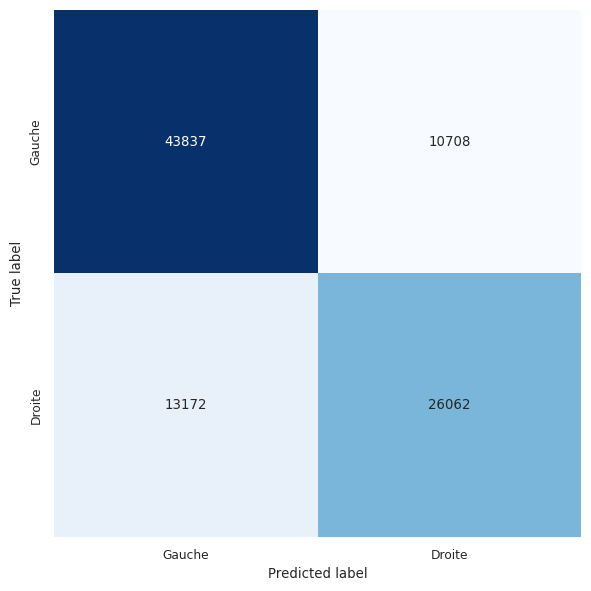

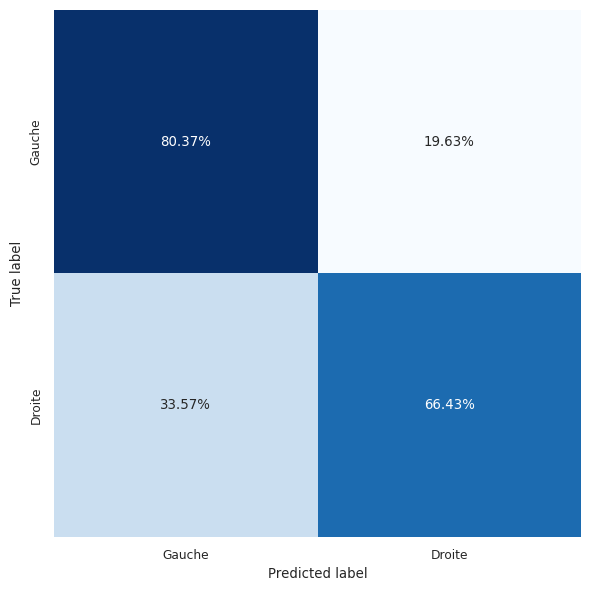

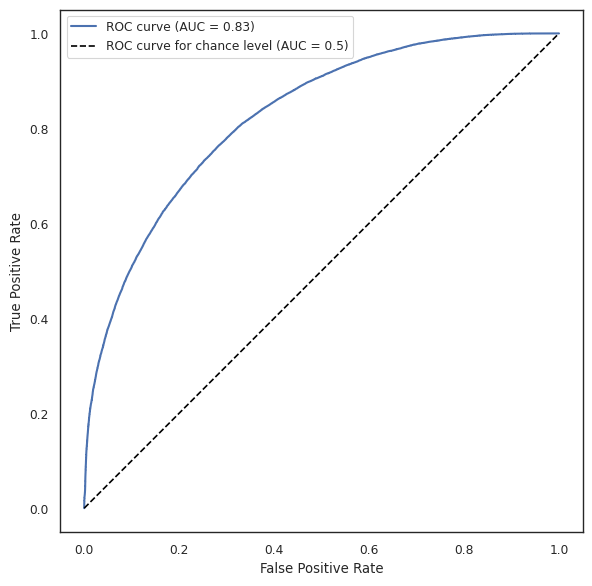

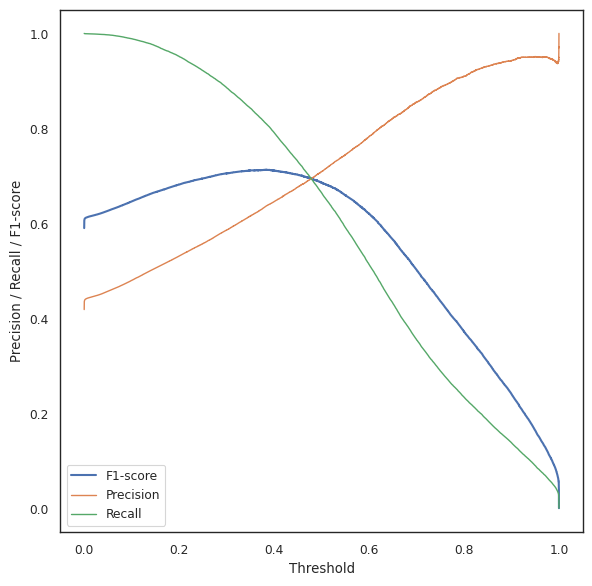

In [150]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Using an Attention Head with feed forward

### Definition of the net architecture

In [13]:
class LinearUnit(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
        )

    def forward(self, x):
        return self.fc(x)


class AttentionUnit(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads=4, dropout=0.2):
        super().__init__()
        self.query_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.key_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.value_linear = LinearUnit(in_dim, in_dim, dropout=dropout)
        self.attn_head = nn.MultiheadAttention(out_dim, n_heads, batch_first=True, dropout=dropout)
        self.layer_norm1 = nn.LayerNorm((3, out_dim))
        self.feed_forward = LinearUnit(out_dim, out_dim, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm((3, out_dim))

    def forward(self, x):
        query = self.query_linear(x)
        key = self.key_linear(x)
        value = self.value_linear(x)
        attn_repr, _ = self.attn_head(query, key, value, need_weights=False)
        attn_repr_summed = x + attn_repr
        normed_repr = self.layer_norm1(attn_repr_summed)
        feed_repr = self.feed_forward(normed_repr)
        feed_repr_summed = normed_repr + feed_repr
        normed_repr2 = self.layer_norm2(feed_repr_summed)
        return normed_repr2


class Net(nn.Module):
    def __init__(
        self,
        root,
        input_dim,
        hidden_dim,
        feature_dim,
        n_heads=4,
        n_attn_layer=1,
        n_classes=2,
        dropout=0.2,
        noise=0.0,
        freeze=True,
    ):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, input_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            },
            "features": torch.randn(32, 2),
        }

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.freeze = freeze
        self.noise = noise
        self.n_attn_layer = n_attn_layer

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        self.features_fc = nn.Sequential(
            LinearUnit(2, feature_dim // 2, dropout=dropout),
            LinearUnit(feature_dim // 2, feature_dim, dropout=dropout),
        )

        self.intervention_fc = LinearUnit(input_dim, hidden_dim, dropout=dropout)

        attn_layers = [
            AttentionUnit(hidden_dim, hidden_dim, n_heads, dropout=dropout)
            for i in range(n_attn_layer)
        ]
        self.attn_heads = nn.Sequential(*attn_layers)

        self.mlp = nn.Sequential(
            LinearUnit(hidden_dim + feature_dim, hidden_dim),
            LinearUnit(hidden_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]
        features = x["features"].float()

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)

        pooled_repr = torch.cat(
            [intervention_repr.unsqueeze(1), titre_repr.unsqueeze(1), contexte_repr.unsqueeze(1)],
            dim=1,
        )

        attn_repr = self.attn_heads(pooled_repr)

        final_repr = torch.cat([attn_repr[:, 0, :].squeeze(1), features_repr], dim=1)

        logits = self.mlp(final_repr)

        return logits

    def forward_without_embeddings(self, **x):
        intervention = x["text"]["intervention"]
        titre_emb = x["text"]["titre_regexed"]
        contexte_emb = x["text"]["contexte"]
        features = x["features"].float()
        intervention_repr = self.intervention_fc(intervention)
        if self.noise > 0:
            titre_emb = titre_emb + torch.randn_like(titre_emb) * self.noise
        titre_repr = self.titre_fc(titre_emb)
        if self.noise > 0:
            contexte_emb = contexte_emb + torch.randn_like(contexte_emb) * self.noise
        contexte_repr = self.contexte_fc(contexte_emb)

        features_repr = self.features_fc(features)
        pooled_repr = torch.cat(
            [intervention_repr.unsqueeze(1), titre_repr.unsqueeze(1), contexte_repr.unsqueeze(1)],
            dim=1,
        )
        attn_repr = self.attn_heads(pooled_repr)
        final_repr = torch.cat([attn_repr[:, 0, :].squeeze(1), features_repr], dim=1)
        logits = self.mlp(final_repr)
        probs = torch.softmax(logits, dim=1)

        return probs

### Experiment definition

In [15]:
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

HIDDEN_DIM = 256
INPUT_DIM = 768
FEATURE_DIM = 16
DROPOUT = 0.2
NUM_CLASSES = 2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = True
N_HEADS = 8
N_ATTN_LAYERS = 2
NOISE = 0.0
MAX_EPOCHS = 250


OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {"weight_decay": 0.005}
LR = 1e-4
LOSS = "CrossEntropyLoss"

# SCHEDULER_KWARGS = {
#     "scheduler": "ExponentialLR",
#     "gamma": 0.9,
# }

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.5,
    "patience": 3,
    "monitor": "val_loss",
}

# SCHEDULER_KWARGS = {
#     "scheduler": "CosineAnnealingWarmRestarts",
#     "T_0": 3,
#     "T_mult": 2,
#     "eta_min": 0,
# }

BASE_ROOT = "../../results/new_features"
POSTFIX = f"ITC_Features_Attn_{N_HEADS}Hx{N_ATTN_LAYERS}@{HIDDEN_DIM}_LN_BS@256_FF"
RESULTS_PATH = f"{BASE_ROOT}/{POSTFIX}_{DROPOUT}_{OPTIMIZER_TYPE}@{LR}"

LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
MIN_DELTA = 0.0
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=3),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(
    root=MODEL_FOLDER,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    feature_dim=FEATURE_DIM,
    n_heads=N_HEADS,
    n_attn_layer=N_ATTN_LAYERS,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    freeze=FREEZE,
).to(device)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [25]:
net_options = dict(
    root=MODEL_FOLDER,
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    feature_dim=FEATURE_DIM,
    n_heads=N_HEADS,
    n_attn_layer=N_ATTN_LAYERS,
    n_classes=NUM_CLASSES,
    dropout=DROPOUT,
    noise=NOISE,
    freeze=FREEZE,
)

In [23]:
f"{CKPT_PATH}/net.plk"

'../../results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/net.plk'

In [26]:
with open(f"{CKPT_PATH}/net_options.pkl", "wb") as f:
    pickle.dump(net_options, f)

In [17]:
trainer.fit(lit_model);

Missing logger folder: ../../results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type          | Params | In sizes     | Out sizes   
------------------------------------------------------------------------------------------------
0  | classifier                     | Net           | 6.0 M  | ?            | [32, 2]     
1  | classifier.titre_embeddings    | Embedding     | 3.9 M  | [32]         | [32, 768]   
2  | classifier.titre_fc            | LinearUnit    | 196 K  | [32, 768]    | [32, 256]   
3  | classifier.titre_fc.fc         | Sequential    | 196 K  | [32, 768]    | [32, 256]   
4  | classifier.contexte_embeddings | Embedding     | 363 K  | [32]         | [32, 768]   
5  | classifier.contexte_fc         | LinearUnit    | 196 K  | [32, 768]    | [32, 256]   
6  | classifier.contexte_fc.fc      | Sequential    | 196 K  | [32, 768]    | [32, 256]   
7  | class

Output()

Metric val_loss improved. New best score: 0.557
Epoch 0, global step 611: 'val_loss' reached 0.55685 (best 0.55685), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=0-step=611.ckpt' as top 1


Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.539
Epoch 1, global step 1222: 'val_loss' reached 0.53887 (best 0.53887), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=1-step=1222.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.527
Epoch 2, global step 1833: 'val_loss' reached 0.52691 (best 0.52691), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=2-step=1833.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.522
Epoch 3, global step 2444: 'val_loss' reached 0.52225 (best 0.52225), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=3-step=2444.ckpt' as top 1


Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.513
Epoch 4, global step 3055: 'val_loss' reached 0.51320 (best 0.51320), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=4-step=3055.ckpt' as top 1


Epoch 5, global step 3666: 'val_loss' was not in top 1


Epoch 6, global step 4277: 'val_loss' was not in top 1


Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.503
Epoch 7, global step 4888: 'val_loss' reached 0.50260 (best 0.50260), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=7-step=4888.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.499
Epoch 8, global step 5499: 'val_loss' reached 0.49946 (best 0.49946), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=8-step=5499.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.499
Epoch 9, global step 6110: 'val_loss' reached 0.49875 (best 0.49875), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=9-step=6110.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.497
Epoch 10, global step 6721: 'val_loss' reached 0.49736 (best 0.49736), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=10-step=6721.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.496
Epoch 11, global step 7332: 'val_loss' reached 0.49596 (best 0.49596), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=11-step=7332.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.494
Epoch 12, global step 7943: 'val_loss' reached 0.49393 (best 0.49393), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=12-step=7943.ckpt' as top 1


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.489
Epoch 13, global step 8554: 'val_loss' reached 0.48884 (best 0.48884), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=13-step=8554.ckpt' as top 1


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.488
Epoch 14, global step 9165: 'val_loss' reached 0.48839 (best 0.48839), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=14-step=9165.ckpt' as top 1


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.488
Epoch 15, global step 9776: 'val_loss' reached 0.48810 (best 0.48810), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=15-step=9776.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.486
Epoch 16, global step 10387: 'val_loss' reached 0.48619 (best 0.48619), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=16-step=10387.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.483
Epoch 17, global step 10998: 'val_loss' reached 0.48271 (best 0.48271), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=17-step=10998.ckpt' as top 1


Epoch 18, global step 11609: 'val_loss' was not in top 1


Epoch 19, global step 12220: 'val_loss' was not in top 1


Epoch 20, global step 12831: 'val_loss' was not in top 1


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.479
Epoch 21, global step 13442: 'val_loss' reached 0.47934 (best 0.47934), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=21-step=13442.ckpt' as top 1


Epoch 22, global step 14053: 'val_loss' was not in top 1


Epoch 23, global step 14664: 'val_loss' was not in top 1


Epoch 24, global step 15275: 'val_loss' was not in top 1


Epoch 25, global step 15886: 'val_loss' was not in top 1


Epoch 26, global step 16497: 'val_loss' was not in top 1


Epoch 27, global step 17108: 'val_loss' was not in top 1


Epoch 28, global step 17719: 'val_loss' was not in top 1


Epoch 29, global step 18330: 'val_loss' was not in top 1


Epoch 30, global step 18941: 'val_loss' was not in top 1


Epoch 31, global step 19552: 'val_loss' was not in top 1


Epoch 32, global step 20163: 'val_loss' was not in top 1


Epoch 33, global step 20774: 'val_loss' was not in top 1


Epoch 34, global step 21385: 'val_loss' was not in top 1


Epoch 35, global step 21996: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.479. Signaling Trainer to stop.
Epoch 36, global step 22607: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=21-step=13442.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/new_features/ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001/lightning_logs/epoch=21-step=13442.ckpt


Output()

Metrics:  {'log_loss': 0.4753170825287484, 'accuracy': 0.7647874257562994, 'balanced_accuracy': 0.7514488346509784, 'recall': 0.6697507264107662, 'precision': 0.742749731471536, 'f1_score': 0.7043639092907307, 'AUC': 0.8494546350960802, 'jaccard_weighted': 0.5436433226440468, 'matthews_weighted': 0.5118133493796778, 'hamming_loss': 0.23521257424370062, 'confusion_matrix': [[45444, 9101], [12957, 26277]], 'confusion_matrix_true_normed': [[0.8331469428911907, 0.16685305710880924], [0.33024927358923384, 0.6697507264107662]], 'confusion_matrix_pred_normed': [[0.7781373606616325, 0.257250268528464], [0.2218626393383675, 0.742749731471536]], 'confusion_matrix_all_normed': [[0.48458610136597746, 0.09704731336439928], [0.13816526087930134, 0.2802013243903219]]}


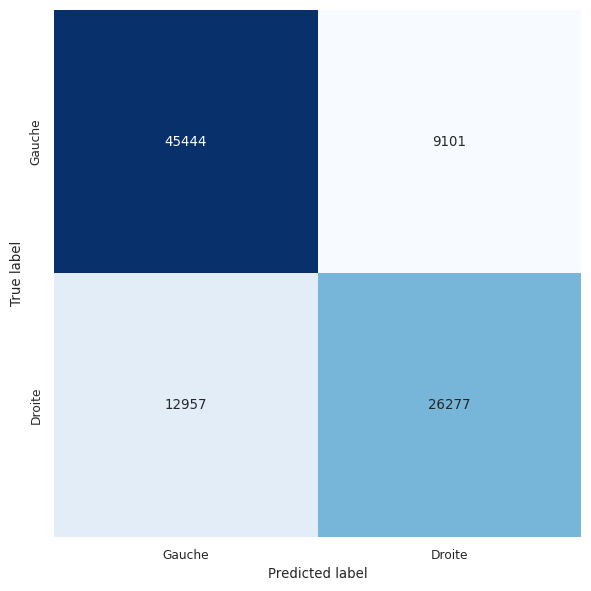

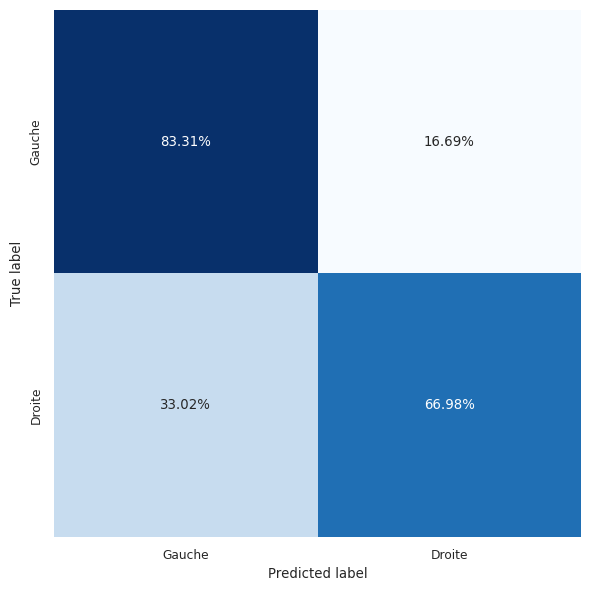

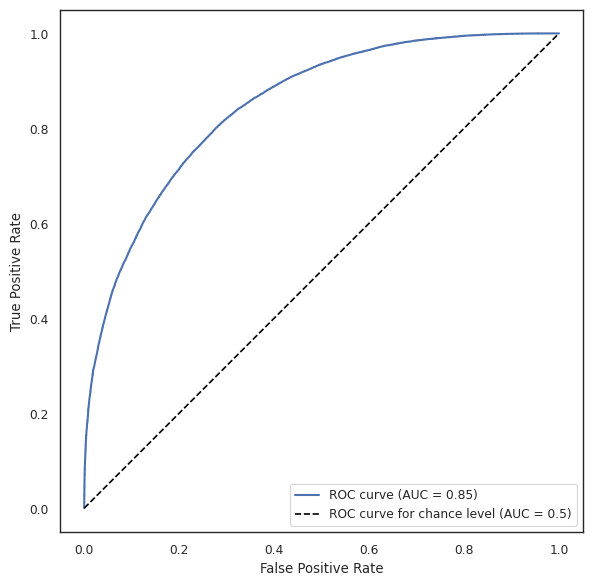

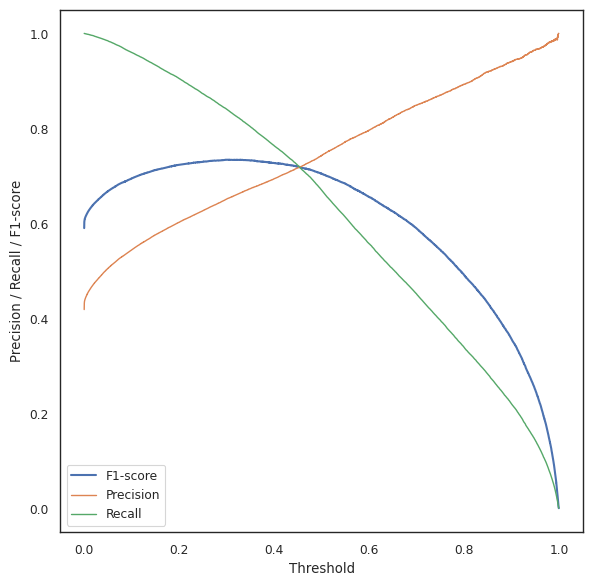

/home/gwatk/Documents/MVA/DL/NLP_Assemblee/nlp_assemblee/simple_visualisation.py:97: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(data=tmp_df, x="probs", hue="y_true", ax=ax, palette=colors, fill=True)


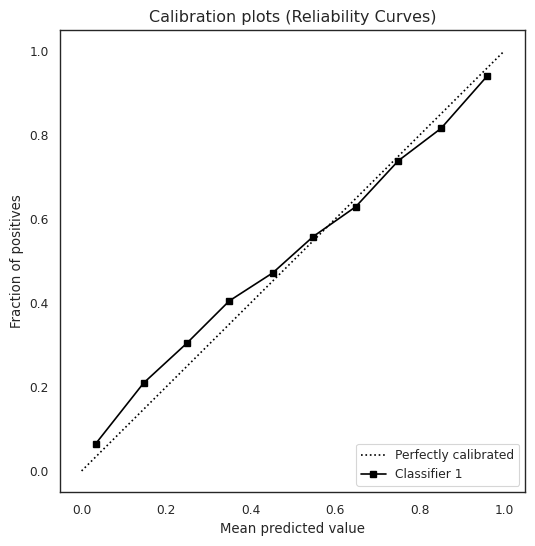

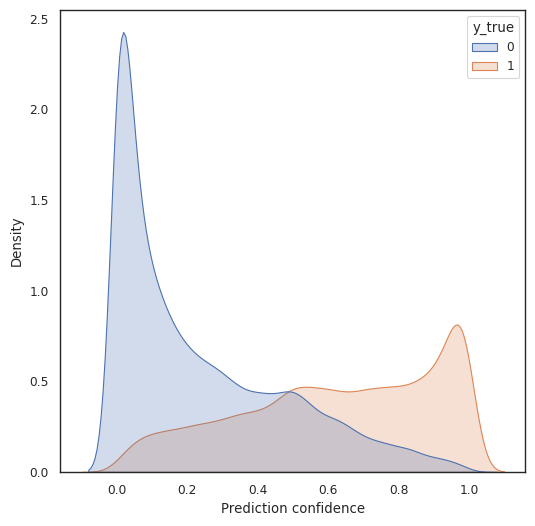

In [18]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

cal_fig = plot_calibration_curve(results, figsize=(6, 6), palette="deep")
cal_fig.savefig(Path(RESULTS_PATH) / "calibration_curve.png")

conf_fig = plot_prediction_confidence(results, figsize=(6, 6), palette="deep")
conf_fig.savefig(Path(RESULTS_PATH) / "prediction_confidence.png")

## Compare metrics

In [14]:
def parse_tensorboard(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()

    scalars = ea.Tags()["scalars"]

    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [15]:
EXP_DIR = "../../results/new_features"
EVENT_FILES = glob(f"{EXP_DIR}/**/lightning_logs/version_*")

In [16]:
res_dict = {}

for f in EVENT_FILES:
    name = Path(f).parent.parent.name
    tmp = parse_tensorboard(f)
    res_dict[name] = tmp

In [17]:
list(res_dict.keys())

['ITC_Features_Attn_8H_0.2_0.0',
 '3_768_0.2_0.05_itc_Features_Frozed_FF',
 'ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001',
 'ITC_Features_Attn_4Hx4@128_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85',
 'ITC_Features_Attn_4Hx3@768_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85',
 '4_768_0.2_0.01_itc_Features_Unfrozed_FF',
 'ITC_Features_Attn_4Hx2@768_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85',
 '4_1024_0.2_0.0',
 '2_768_0.2_0.05_itc_F',
 'ITC_Features_Attn_4Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85',
 'ITC_Features_Attn_4Hx1@384_LN_BS@256_FF_0.2_AdamW@0.0001',
 'ITC_Features_Attn_4H_0.2_0.0',
 '4_1024_0.2_0.01_itc_Features',
 'ITC_Features_Attn_4Hx2@384_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85',
 '4_768_0.2_0.05_itc_Features_Frozed_FF',
 '3_1024_0.3_0.1_itc_Features_Frozed',
 'ONLY_I_4_1024_0.2_0.0',
 '3_384_0.2_0.1_itc_F',
 'ITC_Features_Attn_4Hx2@768_LN_BS@256_FF_0.2_AdamW@0.005_ExpLR@0.85',
 '3_1024_0.2_0.1_itc_F',
 '4_1024_0.2_0.3',
 '3_1024_0.3_0.1_itcp_F',
 'ITC_Features_At

In [41]:
models = {
    "ITC_Features_Attn_8Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0001": "Transformer Head (8H+2L@256)",
    "ITC_Features_Attn_4Hx2@256_LN_BS@256_FF_0.2_AdamW@0.0005_ExpLR@0.85": "Transformer Head (4H+2L@256)",
    "ITC_Features_Attn_4Hx3@384_LN_0.2_AdamW@1e-3_ExpLR@0.9": "Transformer Head (4H+3L@384)",
    "3_1024_0.2_0.02_itc": "Standard (3L@1024)",
    # "3_768_0.2_0.0_itc_Features_Unfrozed_FF": "Features+Unfrozed (3L@768)",
    "3_1024_0.2_0.1_itc_F": "Features (3L@1024)",
    "3_384_0.2_0.1_itc_F": "Features+Concat (3L@384)",
    "3_1024_0.3_0.1_itcp_F": "Features+Profession (3L@1024)",
    "ONLY_I_4_1024_0.2_0.0": "Only Intervenions (4L@1024)",
}

In [48]:
logs = {}

logs_files = glob(f"{EXP_DIR}/**/logs.json")
logs_files = [Path(f) for f in logs_files]

logs_index = [f for f in logs_files if f.parent.name in models]
logs_names = [m.parent.name for m in logs_index]

for f, n in zip(logs_index, logs_names):
    with open(f, "r") as file:
        logs[models[n]] = json.load(file)

log_df = pd.DataFrame()

for model in logs:
    tmp = {
        "model": model,
        "last_epoch": logs[model]["last_epoch"],
        "trainable_parameters": logs[model]["trainable_parameters"],
        "model_size": logs[model]["model_size"],
        "log_loss": logs[model]["metrics"]["log_loss"],
        "accuracy": logs[model]["metrics"]["accuracy"],
        "recall": logs[model]["metrics"]["recall"],
        "precision": logs[model]["metrics"]["precision"],
        "f1_score": logs[model]["metrics"]["f1_score"],
        "AUC": logs[model]["metrics"]["AUC"],
        "optimizer_type": logs[model]["hparams"]["optimizer_type"],
        "learning_rate": logs[model]["hparams"]["learning_rate"],
    }

    log_df = log_df.append(tmp, ignore_index=True)

/tmp/ipykernel_37293/1933519121.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_37293/1933519121.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_37293/1933519121.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_37293/1933519121.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append(tmp, ignore_index=True)
/tmp/ipykernel_37293/1933519121.py:31: FutureWarning: The frame.append method is deprecated and will be removed from

In [49]:
log_df.sort_values(by="log_loss", ascending=True, inplace=True)
log_df.set_index("model", inplace=True)
log_df.to_csv(f"{EXP_DIR}/logs_df.csv", index=True)
log_df.to_latex(f"{EXP_DIR}/logs_df.tex", index=True)
log_df

/tmp/ipykernel_37293/4096754209.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  log_df.to_latex(f"{EXP_DIR}/logs_df.tex", index=True)


,last_epoch,trainable_parameters,model_size,log_loss,accuracy,recall,precision,f1_score,AUC,optimizer_type,learning_rate
model,,,,,,,,,,,
Features+Profession (3L@1024),19,5251074,39.058440,0.096482,0.961580,0.952516,0.955511,0.954011,0.994693,AdamW,0.0010
Transformer Head (4H+3L@384),49,4602450,35.520840,0.462555,0.771793,0.723862,0.728822,0.726333,0.856172,AdamW,0.0005
Transformer Head (4H+2L@256),14,1724498,24.009032,0.467488,0.767592,0.681526,0.741946,0.710454,0.852871,AdamW,0.0005
Transformer Head (8H+2L@256),21,1719978,23.990952,0.475317,0.764787,0.669751,0.742750,0.704364,0.849455,AdamW,0.0001
Features+Concat (3L@384),14,3118210,29.583880,0.491502,0.750957,0.662079,0.720095,0.689869,0.831248,AdamW,0.0010
Standard (3L@1024),14,8741378,34.965512,0.502168,0.748345,0.699088,0.699301,0.699194,0.831240,Adam,0.0005
Only Intervenions (4L@1024),15,3938306,15.753224,0.555797,0.706501,0.546898,0.687636,0.609245,0.775066,Adam,0.0005


In [44]:
rename_to_models = {v: k for k, v in models.items()}
models = {rename_to_models[k]: k for k in log_df.index}

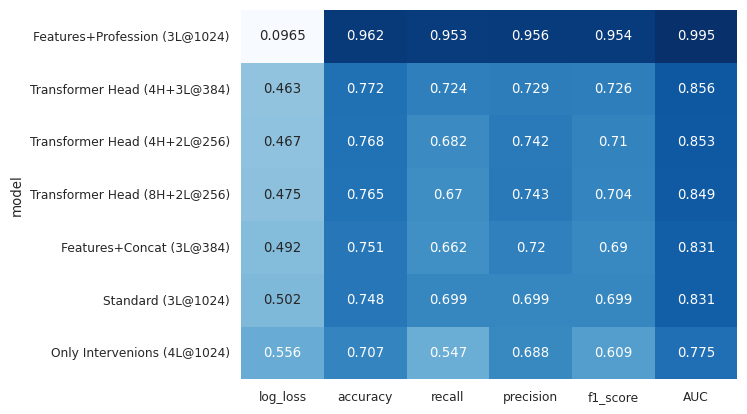

In [45]:
g = sns.heatmap(
    log_df[["log_loss", "accuracy", "recall", "precision", "f1_score", "AUC"]],
    annot=True,
    fmt=".3g",
    cmap="Blues",
    cbar=False,
)

g.figure.savefig(f"{EXP_DIR}/heatmap_metrics.png")

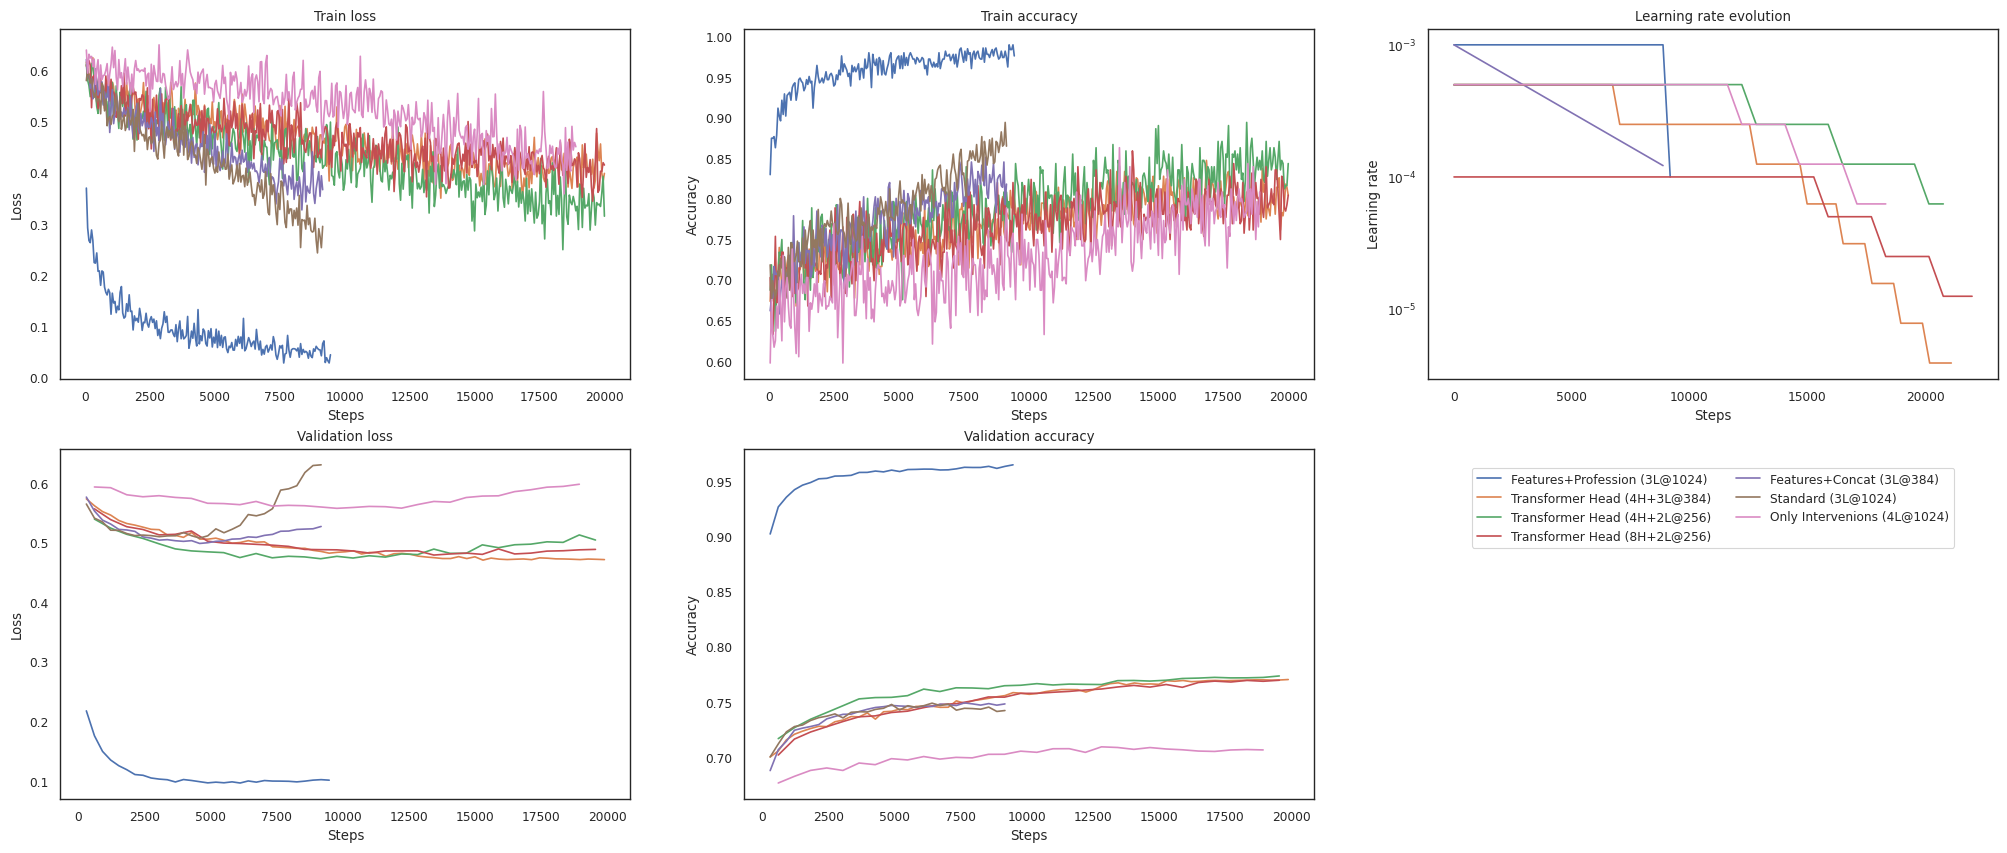

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(25, 10))

colors = sns.color_palette("deep", len(res_dict))
max_step = 20000

for i, model in enumerate(models):
    tmp = res_dict[model]
    try:
        for k in ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]:
            tmp[k] = tmp[k][tmp[k]["step"] < max_step]

        train_steps = tmp["train_loss"]["step"]
        train_loss = tmp["train_loss"]["value"]
        val_steps = tmp["val_loss"]["step"]
        val_loss = tmp["val_loss"]["value"]
        train_acc = tmp["train_accuracy"]["value"]
        val_acc = tmp["val_accuracy"]["value"]
        lr_key = list(tmp.keys())[1]
        lr_steps = tmp[lr_key]["step"]
        lr_val = tmp[lr_key]["value"]

        axs[0, 0].plot(train_steps, train_loss, label=models[model], color=colors[i])
        axs[1, 0].plot(val_steps, val_loss, color=colors[i], linestyle="-")
        axs[0, 0].set(xlabel="Steps", ylabel="Loss", title="Train loss")
        axs[1, 0].set(xlabel="Steps", ylabel="Loss", title="Validation loss")

        axs[0, 1].plot(train_steps, train_acc, label=models[model], color=colors[i])
        axs[1, 1].plot(val_steps, val_acc, color=colors[i], linestyle="-")
        axs[0, 1].set(xlabel="Steps", ylabel="Accuracy", title="Train accuracy")
        axs[1, 1].set(xlabel="Steps", ylabel="Accuracy", title="Validation accuracy")

        axs[0, 2].plot(lr_steps, lr_val, label=models[model], color=colors[i])
        axs[0, 2].set(
            xlabel="Steps", ylabel="Learning rate", title="Learning rate evolution", yscale="log"
        )
        axs[0, 2].legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)

        axs[1, 2].axis("off")
    except:
        continue


fig.savefig(f"{EXP_DIR}/loss_evolution.pdf")